In [1166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline as Pipeline_lasso
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

## Stroke Model Prediction

This notebook was created to train a model to predict whether an individual has stroke or not. 

## Dataset
The stroke dataset has 5110 instances. As can be seen below, the dataset is imbalanced.

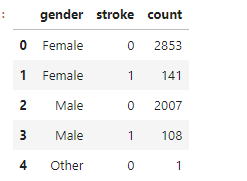

## Feature Selection
Two sets of data were used to train the model.
1. All features
2. Important Features

## Machine Learning Models
Few Classification Machine Learning Algorithms were trained.
1. Logistic Regression 
2. Multilayer Perception (MLP)
3. Decision Tree
4. Random Forest Model

## Machine Learning Technique
Few machine learning techniques were invested to deal with the imbalanced dataset.
1. SMOTE - Oversample
2. SMOTE - Undersample

## Graphs and Classification Metrics
Confusion Matrix and other metrics such as Accuracy, Precision, Recall, F1 and Cross Validation were reported.


### Function

In [1167]:
def conf_mat(y_test, y_test_predicted):
    cm = confusion_matrix(y_test, y_test_predicted)
    
    fn = cm[1, 0]  # False Negatives
    tp = cm[1, 1]  # True Positives
    false_negative_rate = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0
    accuracy = accuracy_score(y_test, y_test_predicted) * 100
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Stroke', 'Stroke'], 
                yticklabels=['No Stroke', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix of Stroke Prediction\n'
              f'Accuracy: {accuracy:.2f}%, FNR: {false_negative_rate:.2f}%')
    plt.show()

### Hyperparameters

#### Random Forest

In [1168]:
random_forest_params = {
 'bootstrap': True, 
 'max_depth': 10, 
 'max_features': 'sqrt', 
 'min_samples_leaf': 4, 
 'min_samples_split': 2, 
 'n_estimators': 500}

#### Decision Tree

In [1169]:
decision_tree_params = {
    'criterion' : 'gini',
    'max_depth': 5,
    'min_samples_split':10,
    'min_samples_leaf':5,
    'max_features': 'sqrt',
    'random_state':42,
    'ccp_alpha':0.01}

#### Read the stroke dataset
The delimiter is comma and the 'id' column is loaded as the index

In [1170]:
original_stroke_data = pd.read_csv("C:/Users/Aditya/Documents/Python_Machine_Learning/stroke_data.csv", sep=",",index_col="id")

#### First ten instances of the dataset

In [1171]:
original_stroke_data.head(10)

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   
56669    Male  81.0             0              0          Yes        Private   
53882    Male  74.0             1              1          Yes        Private   
10434  Female  69.0             0              0           No        Private   
27419  Female  59.0             0              0          Yes        Private   
60491  Female  78.0             0              0          Yes        Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1  
56669          Urban             186.21  29.0  formerly smoked       1  
53882          Rural              70.09  27.4     never smoked       1  
10434          Urban              94.39  22.8     never smoked       1  
27419          Rural              76.15   NaN          Unknown       1  
60491          Urban              58.57  24.2          Unknown       1

#### Last ten instances of the dataset

In [1172]:
original_stroke_data.tail(10)

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
68398    Male  82.0             1              0          Yes  Self-employed   
36901  Female  45.0             0              0          Yes        Private   
45010  Female  57.0             0              0          Yes        Private   
22127  Female  18.0             0              0           No        Private   
14180  Female  13.0             0              0           No       children   
18234  Female  80.0             1              0          Yes        Private   
44873  Female  81.0             0              0          Yes  Self-employed   
19723  Female  35.0             0              0          Yes  Self-employed   
37544    Male  51.0             0              0          Yes        Private   
44679  Female  44.0             0              0          Yes       Govt_job   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
68398          Rural              71.97  28.3     never smoked       0  
36901          Urban              97.95  24.5          Unknown       0  
45010          Rural              77.93  21.7     never smoked       0  
22127          Urban              82.85  46.9          Unknown       0  
14180          Rural             103.08  18.6          Unknown       0  
18234          Urban              83.75   NaN     never smoked       0  
44873          Urban             125.20  40.0     never smoked       0  
19723          Rural              82.99  30.6     never smoked       0  
37544          Rural             166.29  25.6  formerly smoked       0  
44679          Urban              85.28  26.2          Unknown       0

#### Datatype of features

In [1173]:
print(original_stroke_data.dtypes)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


#### Correlation between all the numerical features

In [1174]:
# Select only numeric columns for correlation calculation
numerical_data = original_stroke_data.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Display the correlation matrix
correlation_matrix

age  hypertension  heart_disease  avg_glucose_level  \
age                1.000000      0.276398       0.263796           0.238171   
hypertension       0.276398      1.000000       0.108306           0.174474   
heart_disease      0.263796      0.108306       1.000000           0.161857   
avg_glucose_level  0.238171      0.174474       0.161857           1.000000   
bmi                0.333398      0.167811       0.041357           0.175502   
stroke             0.245257      0.127904       0.134914           0.131945   

                        bmi    stroke  
age                0.333398  0.245257  
hypertension       0.167811  0.127904  
heart_disease      0.041357  0.134914  
avg_glucose_level  0.175502  0.131945  
bmi                1.000000  0.042374  
stroke             0.042374  1.000000

#### Statistical summary of numerical features

In [1175]:
original_stroke_data.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

#### NaN values in the dataset

In [1176]:
original_stroke_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [1177]:
original_stroke_data.loc[original_stroke_data.bmi.isna(),"gender"].value_counts()

gender
Male      104
Female     97
Name: count, dtype: int64

### Gender distribution in the dataset

In [1178]:
original_stroke_data.loc[:,"gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [1179]:
original_stroke_data[original_stroke_data["gender"]=='Other']

gender   age  hypertension  heart_disease ever_married work_type  \
id                                                                       
56156  Other  26.0             0              0           No   Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
56156          Rural             143.33  22.4  formerly smoked       0

In [1180]:
original_stroke_data.groupby(["gender", "stroke"]).size().reset_index(name='count')

gender  stroke  count
0  Female       0   2853
1  Female       1    141
2    Male       0   2007
3    Male       1    108
4   Other       0      1

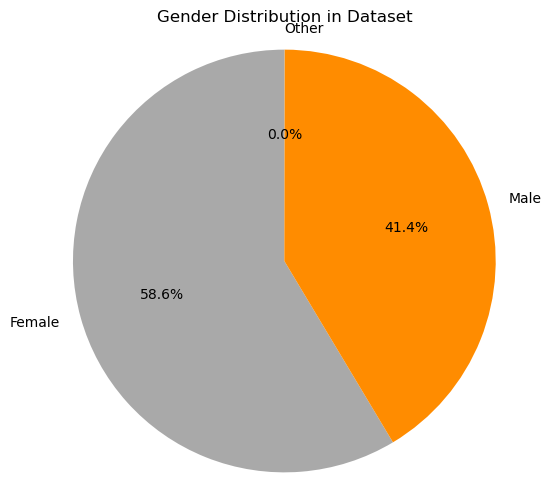

In [1181]:
gender_counts = original_stroke_data['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['darkgray', 'darkorange'])
plt.title('Gender Distribution in Dataset')
plt.axis('equal') 
plt.show()

### The Histograms below shows the distribution of all the features and its association with stroke risk

#### Gender vs Stroke

In [1182]:
original_stroke_data.groupby(["stroke","gender"]).size().reset_index(name='count')

stroke  gender  count
0       0  Female   2853
1       0    Male   2007
2       0   Other      1
3       1  Female    141
4       1    Male    108

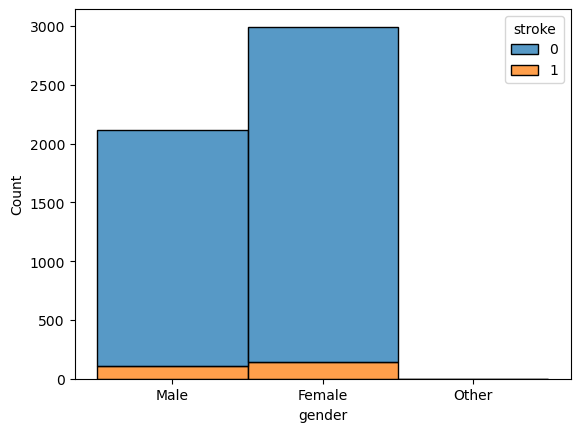

In [1183]:
sns.histplot(x="gender",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Age vs Stroke

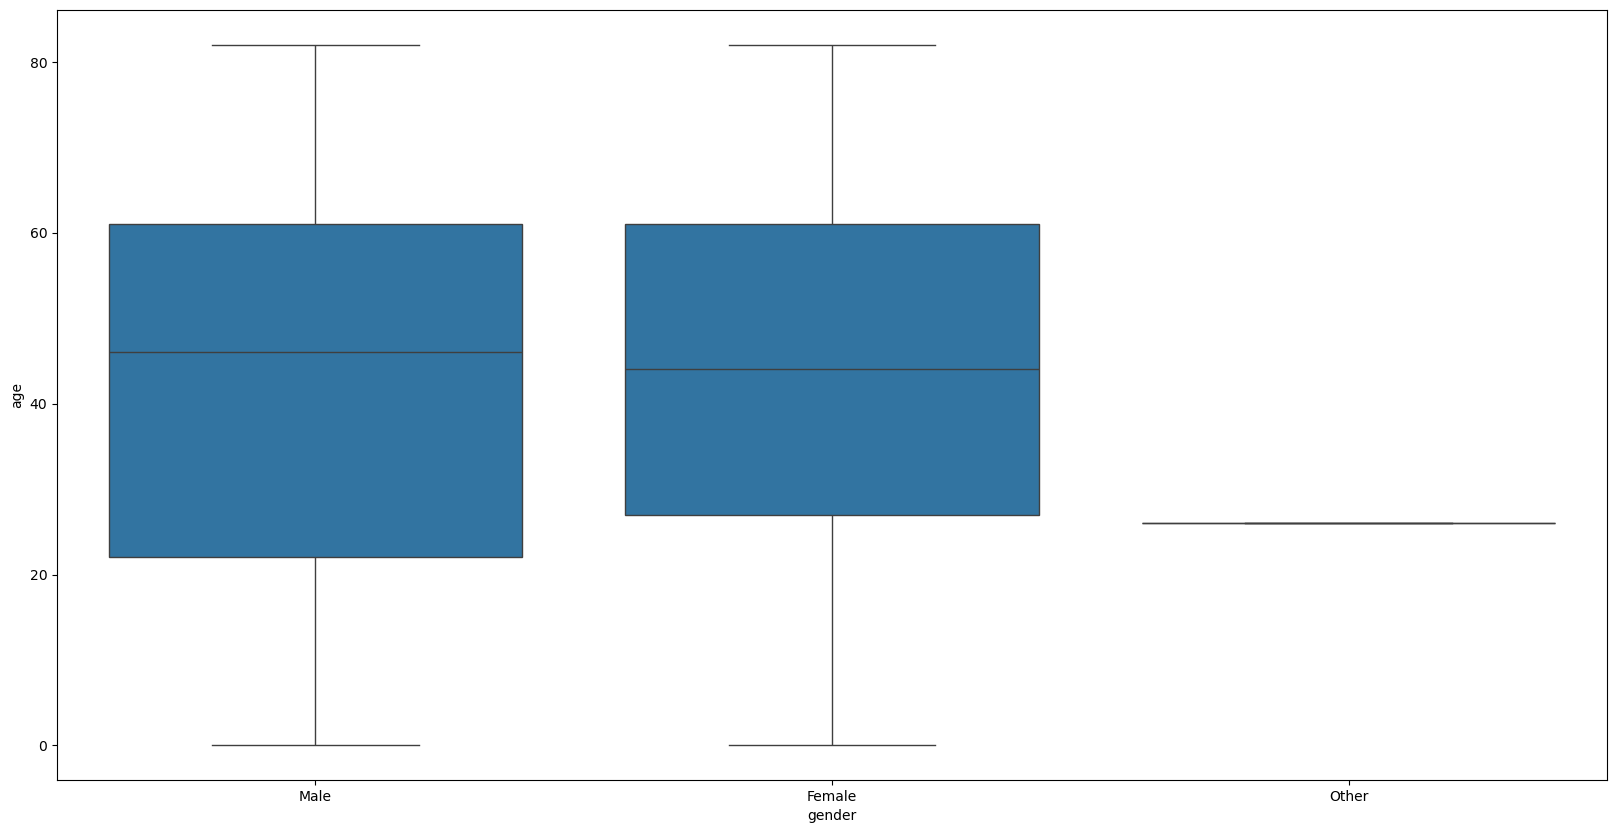

In [1184]:
plt.figure(figsize=(20,10))
sns.boxplot(x=original_stroke_data.gender,y=original_stroke_data.age)
plt.show()

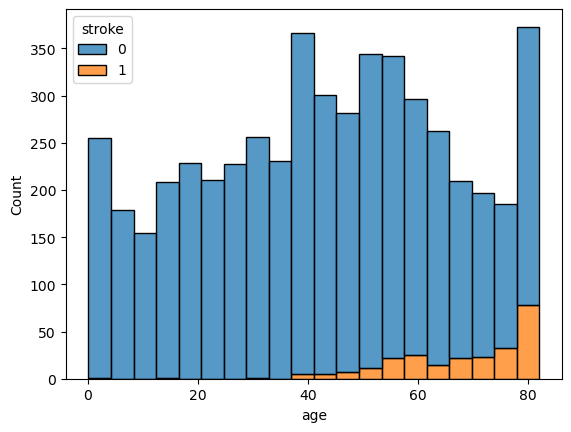

In [1185]:
sns.histplot(x="age",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Hypertension vs Stroke

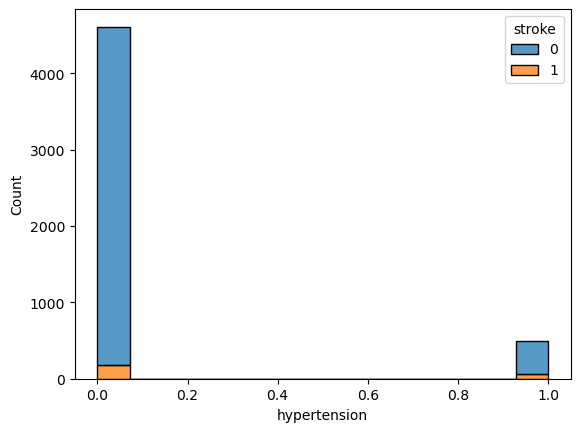

In [1186]:
sns.histplot(x="hypertension",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Smoking Status vs Stroke

In [1187]:
original_stroke_data['smoking_status'].value_counts().reset_index()

smoking_status  count
0     never smoked   1892
1          Unknown   1544
2  formerly smoked    885
3           smokes    789

In [1188]:
original_stroke_data.groupby(["stroke","smoking_status"]).size().reset_index(name='Count')

stroke   smoking_status  Count
0       0          Unknown   1497
1       0  formerly smoked    815
2       0     never smoked   1802
3       0           smokes    747
4       1          Unknown     47
5       1  formerly smoked     70
6       1     never smoked     90
7       1           smokes     42

In [1189]:
original_stroke_data.groupby(["stroke","smoking_status","gender"]).size().reset_index(name='Count')

stroke   smoking_status  gender  Count
0        0          Unknown  Female    811
1        0          Unknown    Male    686
2        0  formerly smoked  Female    443
3        0  formerly smoked    Male    371
4        0  formerly smoked   Other      1
5        0     never smoked  Female   1166
6        0     never smoked    Male    636
7        0           smokes  Female    433
8        0           smokes    Male    314
9        1          Unknown  Female     25
10       1          Unknown    Male     22
11       1  formerly smoked  Female     34
12       1  formerly smoked    Male     36
13       1     never smoked  Female     63
14       1     never smoked    Male     27
15       1           smokes  Female     19
16       1           smokes    Male     23

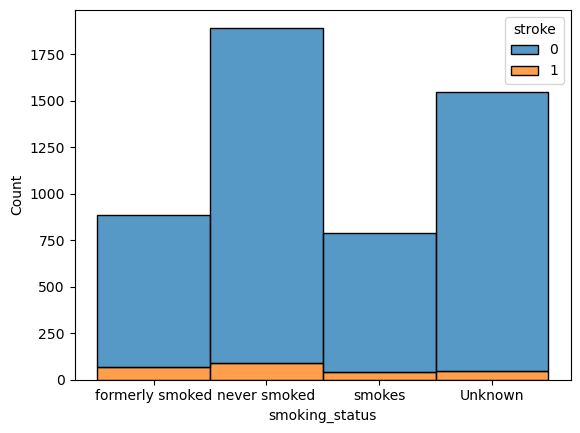

In [1190]:
sns.histplot(x="smoking_status",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Ever_Married vs Stroke

In [1191]:
original_stroke_data["ever_married"].value_counts().reset_index()

ever_married  count
0          Yes   3353
1           No   1757

In [1192]:
original_stroke_data.groupby(["stroke","ever_married"]).size().reset_index(name='count')

stroke ever_married  count
0       0           No   1728
1       0          Yes   3133
2       1           No     29
3       1          Yes    220

In [1193]:
original_stroke_data.groupby(["stroke","ever_married","gender"]).size().reset_index(name='count')

stroke ever_married  gender  count
0       0           No  Female    972
1       0           No    Male    755
2       0           No   Other      1
3       0          Yes  Female   1881
4       0          Yes    Male   1252
5       1           No  Female     21
6       1           No    Male      8
7       1          Yes  Female    120
8       1          Yes    Male    100

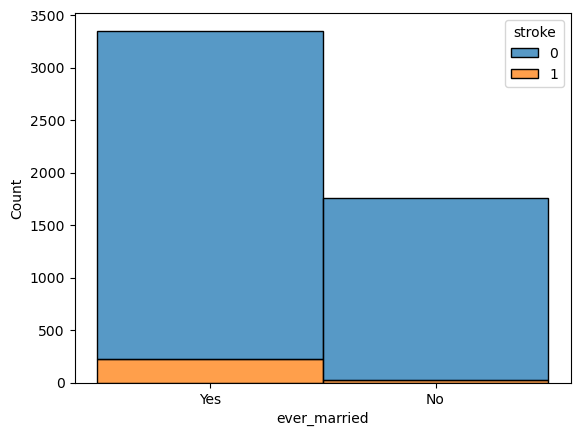

In [1194]:
sns.histplot(x="ever_married",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Heart disease vs Stroke

In [1195]:
original_stroke_data["heart_disease"].value_counts().reset_index()

heart_disease  count
0              0   4834
1              1    276

In [1196]:
original_stroke_data.groupby(["heart_disease","stroke"]).size().reset_index(name='count')

heart_disease  stroke  count
0              0       0   4632
1              0       1    202
2              1       0    229
3              1       1     47

In [1197]:
original_stroke_data.groupby(["heart_disease","stroke","gender"]).size().reset_index(name='count')

heart_disease  stroke  gender  count
0              0       0  Female   2759
1              0       0    Male   1872
2              0       0   Other      1
3              0       1  Female    122
4              0       1    Male     80
5              1       0  Female     94
6              1       0    Male    135
7              1       1  Female     19
8              1       1    Male     28

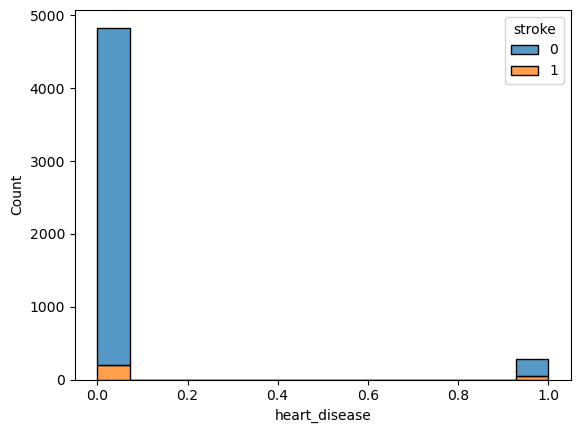

In [1198]:
sns.histplot(x="heart_disease",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Work_type vs Stroke

In [1199]:
original_stroke_data["work_type"].value_counts().reset_index()

work_type  count
0        Private   2925
1  Self-employed    819
2       children    687
3       Govt_job    657
4   Never_worked     22

In [1200]:
original_stroke_data.groupby(["work_type", "stroke"]).size().reset_index(name='count')

work_type  stroke  count
0       Govt_job       0    624
1       Govt_job       1     33
2   Never_worked       0     22
3        Private       0   2776
4        Private       1    149
5  Self-employed       0    754
6  Self-employed       1     65
7       children       0    685
8       children       1      2

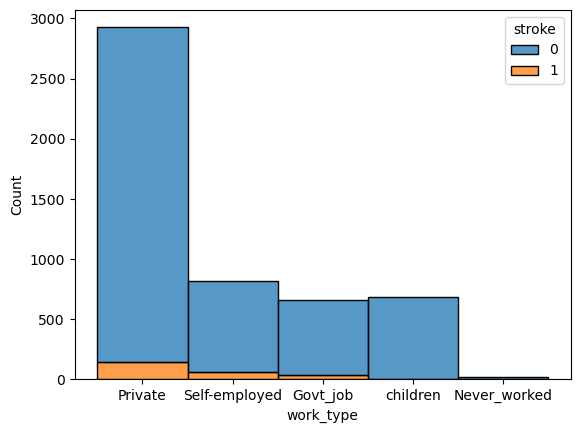

In [1201]:
sns.histplot(x="work_type",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### Residence Type vs Stroke

In [1202]:
original_stroke_data["Residence_type"].value_counts().reset_index()

Residence_type  count
0          Urban   2596
1          Rural   2514

In [1203]:
original_stroke_data.groupby(["Residence_type", "stroke"]).size().reset_index(name='count')

Residence_type  stroke  count
0          Rural       0   2400
1          Rural       1    114
2          Urban       0   2461
3          Urban       1    135

In [1204]:
original_stroke_data.groupby(["Residence_type", "stroke","gender"]).size().reset_index(name='count')

Residence_type  stroke  gender  count
0          Rural       0  Female   1401
1          Rural       0    Male    998
2          Rural       0   Other      1
3          Rural       1  Female     64
4          Rural       1    Male     50
5          Urban       0  Female   1452
6          Urban       0    Male   1009
7          Urban       1  Female     77
8          Urban       1    Male     58

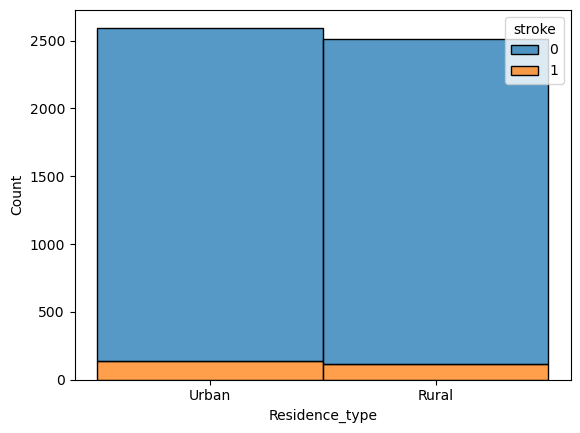

In [1205]:
sns.histplot(x="Residence_type",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

#### BMI (Body Mass Index) vs Stroke

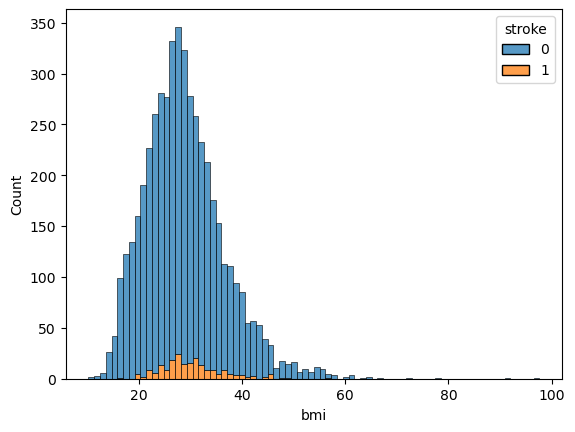

In [1206]:
sns.histplot(x="bmi",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

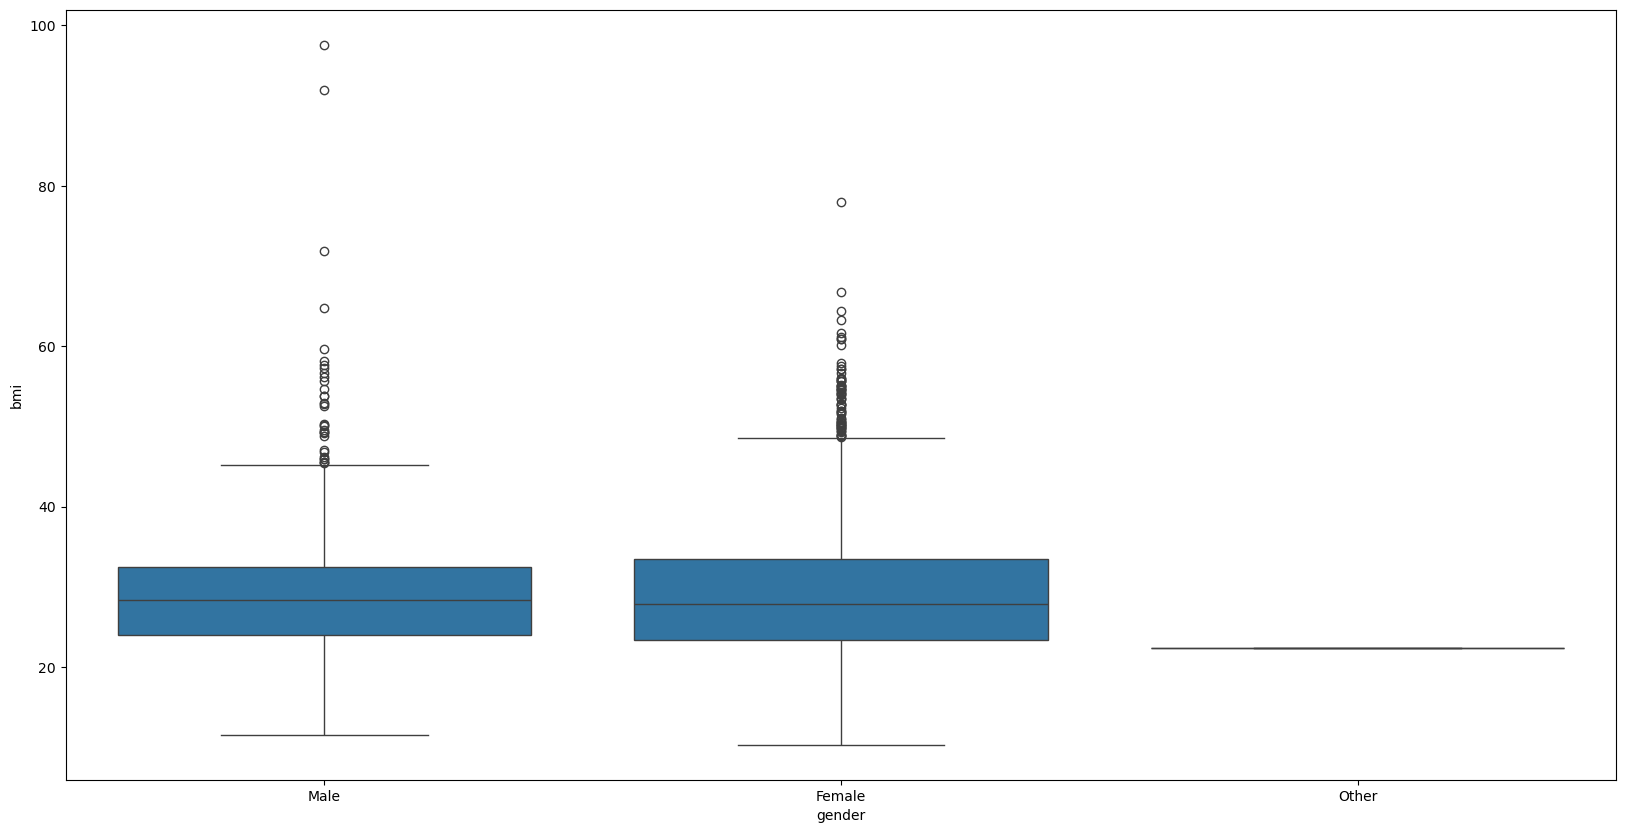

In [1207]:
plt.figure(figsize=(20,10))
sns.boxplot(x=original_stroke_data.gender,y=original_stroke_data.bmi)
plt.show()

#### Average glucose level vs Stroke

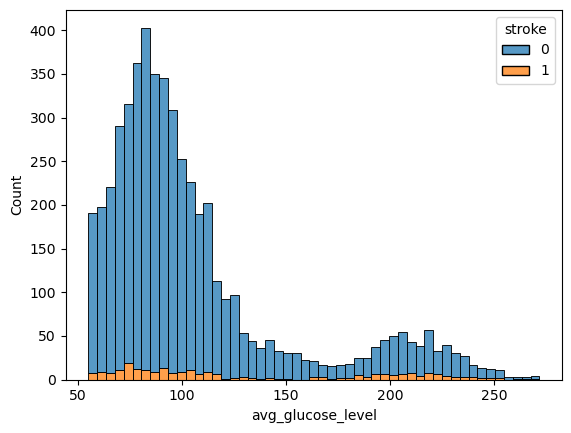

In [1208]:
sns.histplot(x="avg_glucose_level",hue="stroke",multiple="stack",data=original_stroke_data)
plt.show()

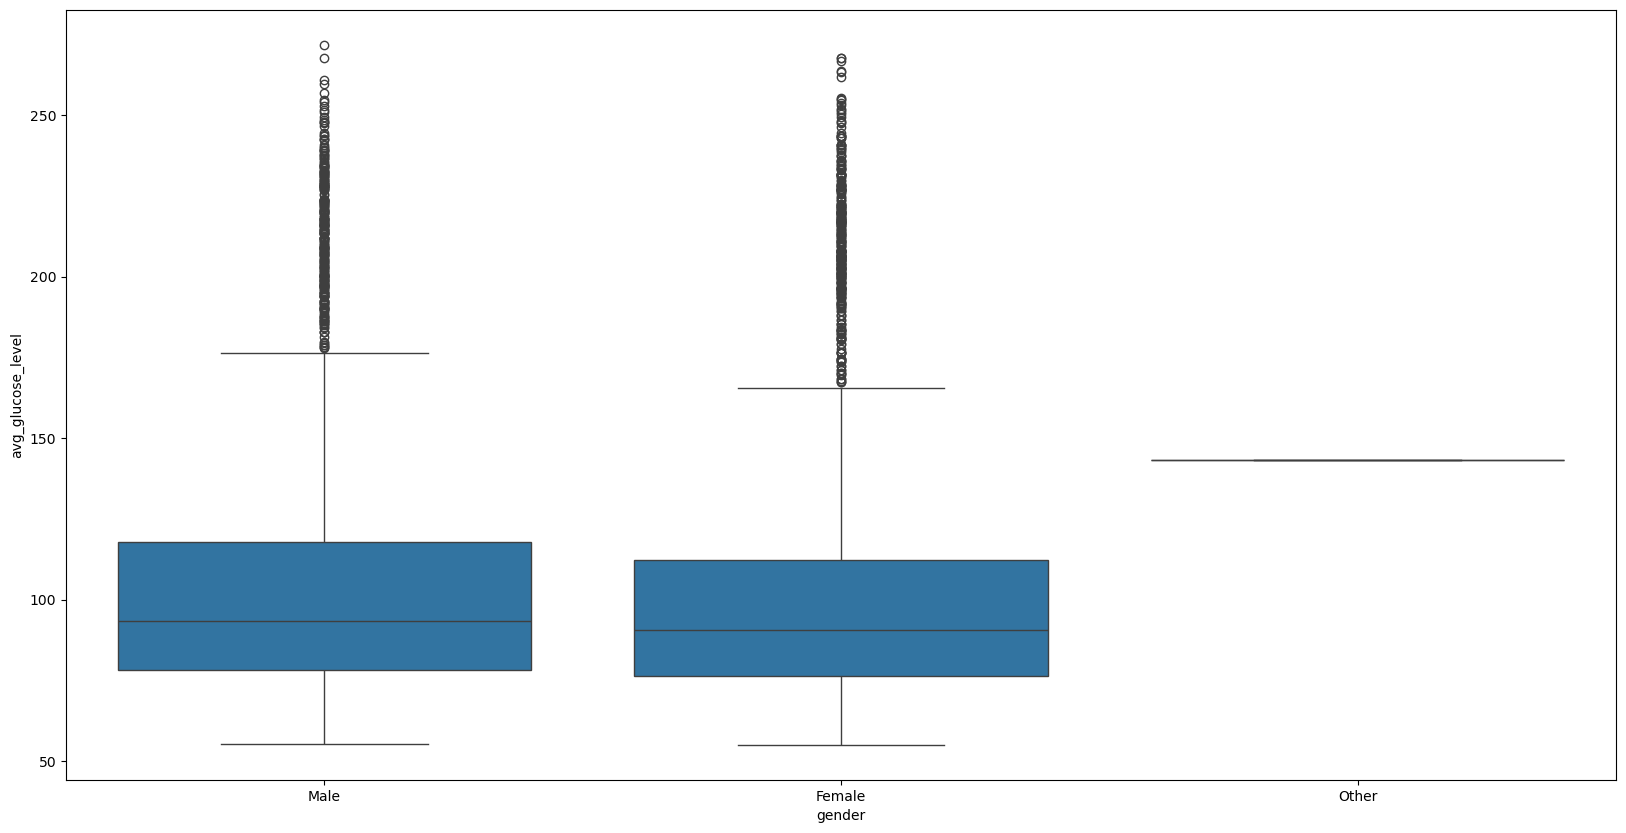

In [1209]:
plt.figure(figsize=(20,10))
sns.boxplot(x=original_stroke_data.gender,y=original_stroke_data.avg_glucose_level)
plt.show()

In [1210]:
original_stroke_data

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   
...       ...   ...           ...            ...          ...            ...   
18234  Female  80.0             1              0          Yes        Private   
44873  Female  81.0             0              0          Yes  Self-employed   
19723  Female  35.0             0              0          Yes  Self-employed   
37544    Male  51.0             0              0          Yes        Private   
44679  Female  44.0             0              0          Yes       Govt_job   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1  
...              ...                ...   ...              ...     ...  
18234          Urban              83.75   NaN     never smoked       0  
44873          Urban             125.20  40.0     never smoked       0  
19723          Rural              82.99  30.6     never smoked       0  
37544          Rural             166.29  25.6  formerly smoked       0  
44679          Urban              85.28  26.2          Unknown       0  

[5110 rows x 11 columns]

## The Histograms below shows the distribution of all the features focusing only on Stroke

In [1211]:
original_stroke_data_only = original_stroke_data[original_stroke_data['stroke'] == 1]

#### Gender vs Stroke

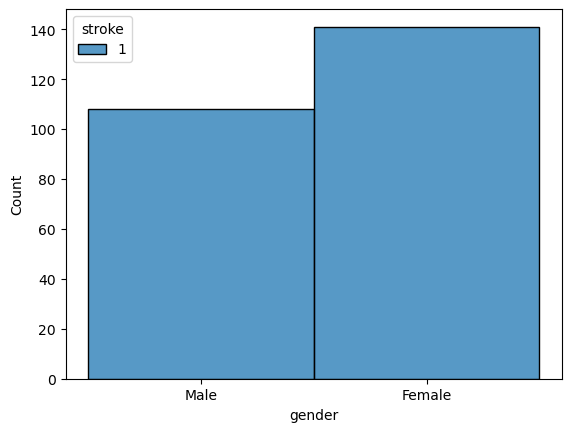

In [1212]:
sns.histplot(x="gender",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### Hypertension vs Stroke

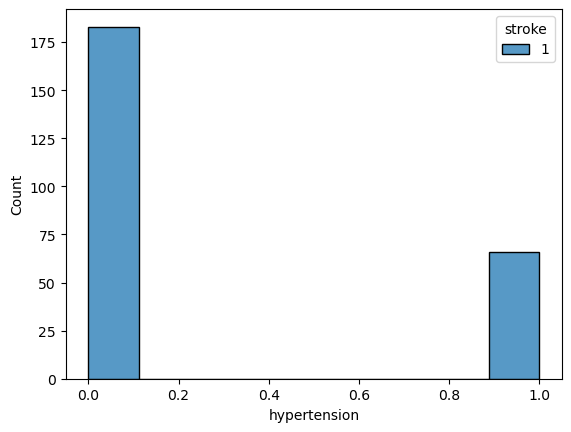

In [1213]:
sns.histplot(x="hypertension",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### Age vs Stroke

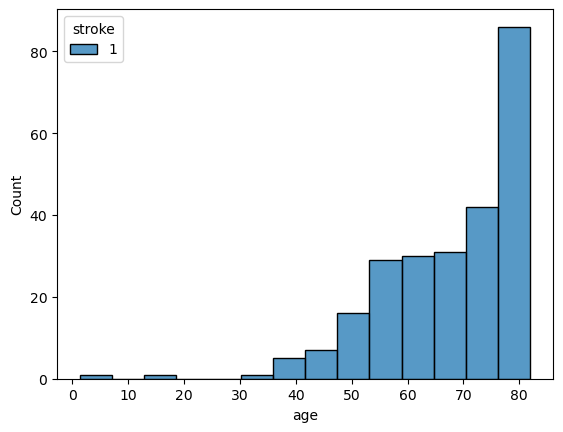

In [1214]:
sns.histplot(x="age",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### Smoking Status vs Stroke

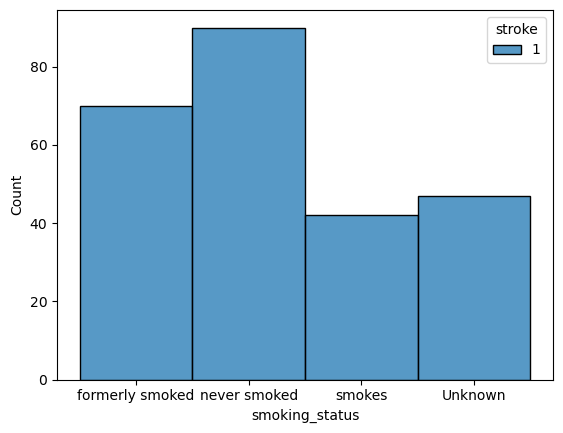

In [1215]:
sns.histplot(x="smoking_status",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### Ever_married vs stroke

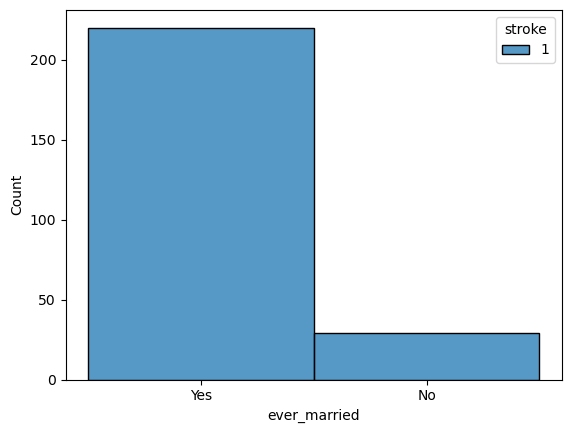

In [1216]:
sns.histplot(x="ever_married",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### heart_disease vs stroke

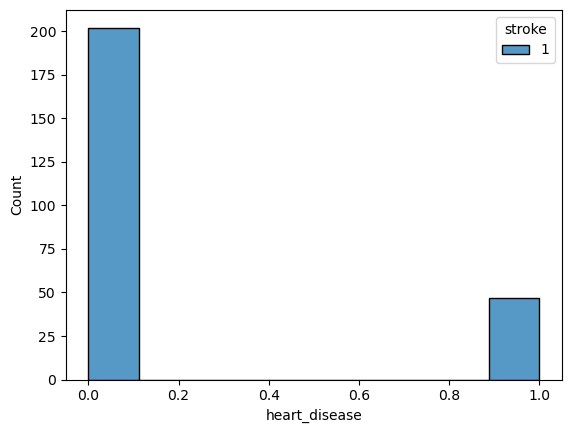

In [1217]:
sns.histplot(x="heart_disease",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### work_type vs stroke

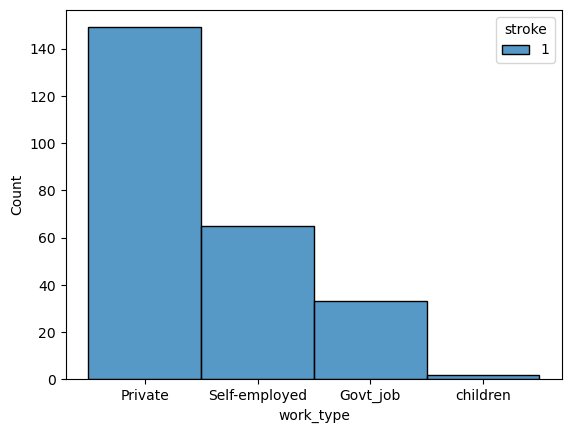

In [1218]:
sns.histplot(x="work_type",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### Residence_type vs stroke

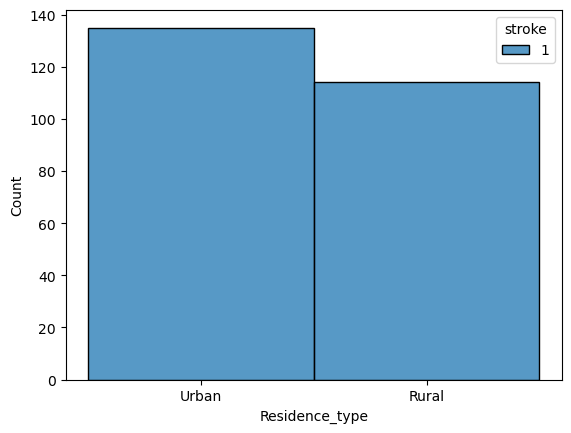

In [1219]:
sns.histplot(x="Residence_type",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### avg_glucose_level vs stroke

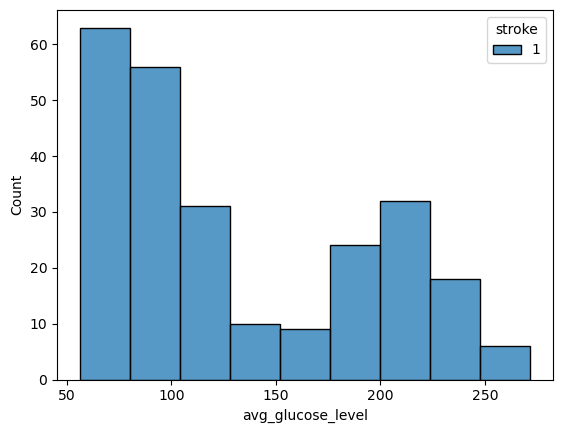

In [1220]:
sns.histplot(x="avg_glucose_level",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

#### bmi vs stroke

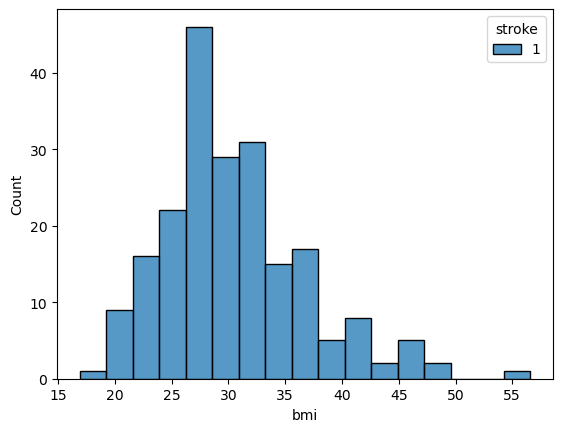

In [1221]:
sns.histplot(x="bmi",hue="stroke",multiple="stack",data=original_stroke_data_only)
plt.show()

### Data Cleaning and Transformation

In [1222]:
#drop the "Other" gender from the dataset
df_cleaned = original_stroke_data[original_stroke_data['gender'] != 'Other']
df_cleaned.gender.unique()

array(['Male', 'Female'], dtype=object)

In [1223]:
df_cleaned

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   
...       ...   ...           ...            ...          ...            ...   
18234  Female  80.0             1              0          Yes        Private   
44873  Female  81.0             0              0          Yes  Self-employed   
19723  Female  35.0             0              0          Yes  Self-employed   
37544    Male  51.0             0              0          Yes        Private   
44679  Female  44.0             0              0          Yes       Govt_job   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1  
...              ...                ...   ...              ...     ...  
18234          Urban              83.75   NaN     never smoked       0  
44873          Urban             125.20  40.0     never smoked       0  
19723          Rural              82.99  30.6     never smoked       0  
37544          Rural             166.29  25.6  formerly smoked       0  
44679          Urban              85.28  26.2          Unknown       0  

[5109 rows x 11 columns]

#### One Hot Encoding

In [1224]:
# convert the categorical gender column to binary
# Male = 1 and Female = 0
df_cleaned.loc[:,["gender"]] = pd.get_dummies(df_cleaned.gender,drop_first=True, dtype=int).values

In [1225]:
# convert the categorical ever_married column to binary
# Yes = 1 and No = 0
df_cleaned.loc[:,["ever_married"]] = pd.get_dummies(df_cleaned.ever_married,drop_first=True, dtype=int).values

In [1226]:
# convert the categorical Residence_type column to binary
# Urban = 1, Rural = 0
df_cleaned.loc[:,["Residence_type"]] = pd.get_dummies(df_cleaned.Residence_type,drop_first=True, dtype=int).values

In [1227]:
# convert the categorical work_type
df_cleaned = pd.concat([df_cleaned,pd.get_dummies(df_cleaned.work_type, dtype=int)],axis=1) .drop(columns="work_type")

In [1228]:
df_cleaned = pd.concat([df_cleaned,pd.get_dummies(df_cleaned.smoking_status, dtype=int)],axis=1) .drop(columns="smoking_status")

In [1229]:
# Fill missing 'bmi' values based on 'gender', and 'age'
df_cleaned['bmi'] = df_cleaned.groupby(['gender', 'age'])['bmi'].transform(lambda x: x.fillna(x.mean()))

In [1230]:
df_cleaned['bmi'] = df_cleaned['bmi'].fillna(df_cleaned['bmi'].mean())

In [1231]:
df_cleaned.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
Residence_type       0
avg_glucose_level    0
bmi                  0
stroke               0
Govt_job             0
Never_worked         0
Private              0
Self-employed        0
children             0
Unknown              0
formerly smoked      0
never smoked         0
smokes               0
dtype: int64

In [1232]:
df_cleaned

gender   age  hypertension  heart_disease ever_married Residence_type  \
id                                                                            
9046       1  67.0             0              1            1              1   
51676      0  61.0             0              0            1              0   
31112      1  80.0             0              1            1              0   
60182      0  49.0             0              0            1              1   
1665       0  79.0             1              0            1              0   
...      ...   ...           ...            ...          ...            ...   
18234      0  80.0             1              0            1              1   
44873      0  81.0             0              0            1              1   
19723      0  35.0             0              0            1              0   
37544      1  51.0             0              0            1              0   
44679      0  44.0             0              0            1              1   

       avg_glucose_level        bmi  stroke  Govt_job  Never_worked  Private  \
id                                                                             
9046              228.69  36.600000       1         0             0        1   
51676             202.21  29.879487       1         0             0        0   
31112             105.92  32.500000       1         0             0        1   
60182             171.23  34.400000       1         0             0        1   
1665              174.12  24.000000       1         0             0        0   
...                  ...        ...     ...       ...           ...      ...   
18234              83.75  28.476923       0         0             0        1   
44873             125.20  40.000000       0         0             0        0   
19723              82.99  30.600000       0         0             0        0   
37544             166.29  25.600000       0         0             0        1   
44679              85.28  26.200000       0         1             0        0   

       Self-employed  children  Unknown  formerly smoked  never smoked  smokes  
id                                                                              
9046               0         0        0                1             0       0  
51676              1         0        0                0             1       0  
31112              0         0        0                0             1       0  
60182              0         0        0                0             0       1  
1665               1         0        0                0             1       0  
...              ...       ...      ...              ...           ...     ...  
18234              0         0        0                0             1       0  
44873              1         0        0                0             1       0  
19723              1         0        0                0             1       0  
37544              0         0        0                1             0       0  
44679              0         0        1                0             0       0  

[5109 rows x 18 columns]

### Data Transformation

In [1233]:
scaler = MinMaxScaler()

In [1234]:
df_scaled = scaler.fit_transform(df_cleaned)

In [1235]:
df_scaled = pd.DataFrame(df_scaled, columns=df_cleaned.columns)

In [1236]:
df_scaled

gender       age  hypertension  heart_disease  ever_married  \
0        1.0  0.816895           0.0            1.0           1.0   
1        0.0  0.743652           0.0            0.0           1.0   
2        1.0  0.975586           0.0            1.0           1.0   
3        0.0  0.597168           0.0            0.0           1.0   
4        0.0  0.963379           1.0            0.0           1.0   
...      ...       ...           ...            ...           ...   
5104     0.0  0.975586           1.0            0.0           1.0   
5105     0.0  0.987793           0.0            0.0           1.0   
5106     0.0  0.426270           0.0            0.0           1.0   
5107     1.0  0.621582           0.0            0.0           1.0   
5108     0.0  0.536133           0.0            0.0           1.0   

      Residence_type  avg_glucose_level       bmi  stroke  Govt_job  \
0                1.0           0.801265  0.301260     1.0       0.0   
1                0.0           0.679023  0.224278     1.0       0.0   
2                0.0           0.234512  0.254296     1.0       0.0   
3                1.0           0.536008  0.276060     1.0       0.0   
4                0.0           0.549349  0.156930     1.0       0.0   
...              ...                ...       ...     ...       ...   
5104             1.0           0.132167  0.208212     0.0       0.0   
5105             1.0           0.323516  0.340206     0.0       0.0   
5106             0.0           0.128658  0.232532     0.0       0.0   
5107             0.0           0.513203  0.175258     0.0       0.0   
5108             1.0           0.139230  0.182131     0.0       1.0   

      Never_worked  Private  Self-employed  children  Unknown  \
0              0.0      1.0            0.0       0.0      0.0   
1              0.0      0.0            1.0       0.0      0.0   
2              0.0      1.0            0.0       0.0      0.0   
3              0.0      1.0            0.0       0.0      0.0   
4              0.0      0.0            1.0       0.0      0.0   
...            ...      ...            ...       ...      ...   
5104           0.0      1.0            0.0       0.0      0.0   
5105           0.0      0.0            1.0       0.0      0.0   
5106           0.0      0.0            1.0       0.0      0.0   
5107           0.0      1.0            0.0       0.0      0.0   
5108           0.0      0.0            0.0       0.0      1.0   

      formerly smoked  never smoked  smokes  
0                 1.0           0.0     0.0  
1                 0.0           1.0     0.0  
2                 0.0           1.0     0.0  
3                 0.0           0.0     1.0  
4                 0.0           1.0     0.0  
...               ...           ...     ...  
5104              0.0           1.0     0.0  
5105              0.0           1.0     0.0  
5106              0.0           1.0     0.0  
5107              1.0           0.0     0.0  
5108              0.0           0.0     0.0  

[5109 rows x 18 columns]

### Data Splitting and Model building

In [1237]:
X = df_scaled.drop(columns=['stroke'])
y = df_scaled['stroke']

In [1238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [1239]:
print(df_cleaned.gender.mean())
print(X_train.gender.mean())
print(X_test.gender.mean())

0.41397533763945976
0.41350623929532665
0.4158512720156556


### Logistic Regression

In [1240]:
lr_model = LogisticRegression(random_state=42,max_iter=1000)

In [1241]:
lr_model.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [1242]:
lr_y_test_predicted = lr_model.predict(X_test)

In [1243]:
(lr_y_test_predicted == y_test).sum()/len(y_test)

0.9510763209393346

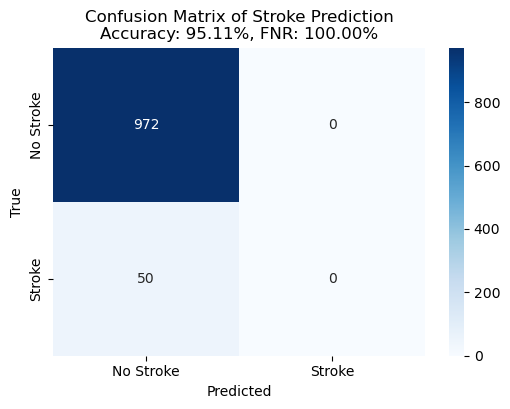

In [1244]:
conf_mat(y_test,lr_y_test_predicted)

In [1245]:
report =classification_report(y_true=y_test, y_pred=lr_y_test_predicted)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1246]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### Multi-layer Perceptron Classifier

In [1247]:
nn_model = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [1248]:
nn_model.fit(X=X_train,y=y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [1249]:
y_test_predicted_nn = nn_model.predict(X_test)

In [1250]:
(y_test_predicted_nn == y_test).sum()/len(y_test)

0.9510763209393346

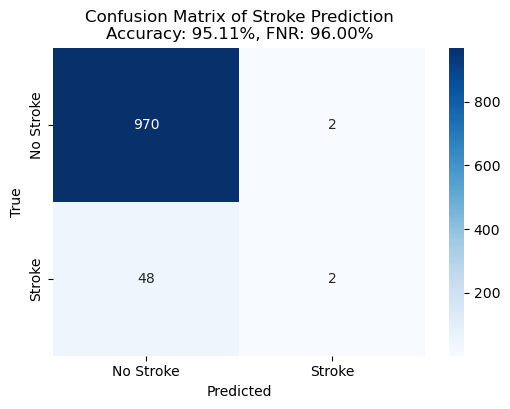

In [1251]:
conf_mat(y_test,y_test_predicted_nn)

In [1252]:
report_nn = classification_report(y_pred=y_test_predicted_nn,y_true=y_test)

In [1253]:
print(report_nn)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.50      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.73      0.52      0.52      1022
weighted avg       0.93      0.95      0.93      1022



### Decision Tree Classifier

In [1254]:
dt_model = DecisionTreeClassifier(**decision_tree_params)

In [1255]:
dt_model.fit(X=X_train,y=y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [1256]:
y_test_predicted_dt = dt_model.predict(X_test)

In [1257]:
(y_test_predicted_dt == y_test).sum()/len(y_test)

0.9510763209393346

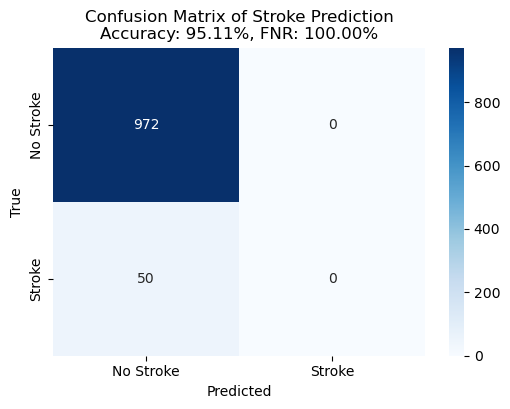

In [1258]:
conf_mat(y_test,y_test_predicted_dt)

In [1259]:
report_dt = classification_report(y_pred=y_test_predicted_dt,y_true=y_test)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1260]:
print(report_dt)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### Random Forest Classifier

In [1261]:
rf_model = RandomForestClassifier(**random_forest_params)

In [1262]:
rf_model.fit(X=X_train,y=y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [1263]:
y_test_predicted_rf = rf_model.predict(X_test)

In [1264]:
(y_test_predicted_rf == y_test).sum()/len(y_test)

0.9510763209393346

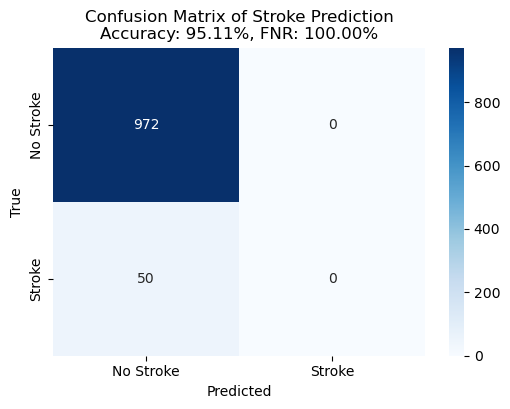

In [1265]:
conf_mat(y_test,y_test_predicted_rf)

In [1266]:
report_rf = classification_report(y_pred=y_test_predicted_rf,y_true=y_test)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1267]:
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



## Features Importances Selection

#### Random Forest Feature Importance

Accuracy: 0.95
              Feature  Importance
1                 age    0.308298
6   avg_glucose_level    0.240729
7                 bmi    0.182174
2        hypertension    0.041385
3       heart_disease    0.030751
0              gender    0.026438
5      Residence_type    0.025449
4        ever_married    0.021918
10            Private    0.020977
15       never smoked    0.020654
11      Self-employed    0.020030
14    formerly smoked    0.018724
16             smokes    0.015445
13            Unknown    0.013787
8            Govt_job    0.010376
12           children    0.002861
9        Never_worked    0.000004


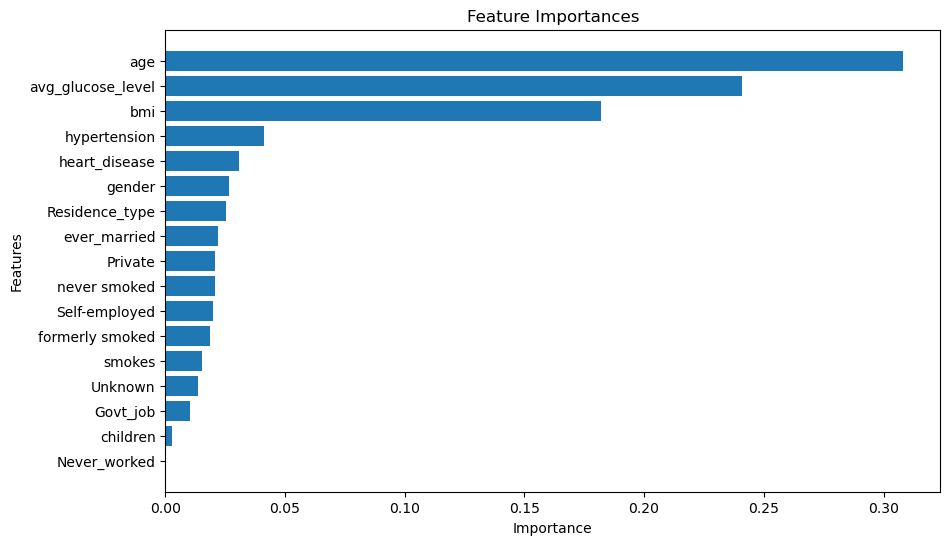

In [1268]:
accuracy = accuracy_score(y_test, y_test_predicted_rf)
print(f"Accuracy: {accuracy:.2f}")

importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#### Random Forest Eliminator

In [1269]:
rfe = RFE(estimator=rf_model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)

Selected Features by RFE: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


#### Correlation Matrix

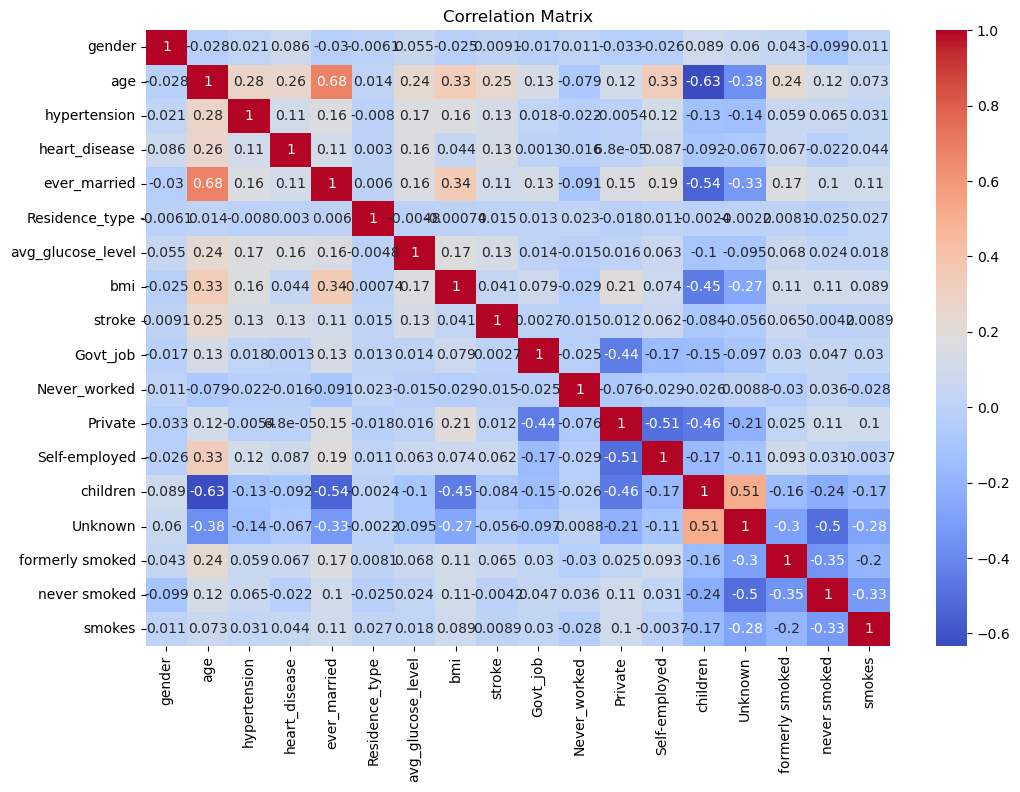

Highly Correlated Features: ['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'stroke']


In [1270]:
correlation_matrix = df_scaled.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

important_features = correlation_matrix['stroke'][correlation_matrix['stroke'].abs() > 0.1].index.tolist()
print("Highly Correlated Features:", important_features)

In [1271]:
correlation_matrix

gender       age  hypertension  heart_disease  \
gender             1.000000 -0.027752      0.021223       0.085685   
age               -0.027752  1.000000      0.276367       0.263777   
hypertension       0.021223  0.276367      1.000000       0.108292   
heart_disease      0.085685  0.263777      0.108292       1.000000   
ever_married      -0.030171  0.679084      0.164187       0.114601   
Residence_type    -0.006105  0.014031     -0.007980       0.003045   
avg_glucose_level  0.054722  0.238323      0.174540       0.161907   
bmi               -0.024861  0.334107      0.164809       0.043515   
stroke             0.009081  0.245239      0.127891       0.134905   
Govt_job          -0.016598  0.129965      0.017661       0.001312   
Never_worked       0.011486 -0.078667     -0.021612      -0.015715   
Private           -0.032502  0.116678     -0.005358       0.000068   
Self-employed     -0.026045  0.327949      0.115417       0.086742   
children           0.089226 -0.634320     -0.129535      -0.091654   
Unknown            0.059557 -0.378366     -0.141551      -0.066765   
formerly smoked    0.043121  0.237347      0.059022       0.066938   
never smoked      -0.098952  0.119207      0.065018      -0.021893   
smokes             0.011408  0.073075      0.031213       0.044030   

                   ever_married  Residence_type  avg_glucose_level       bmi  \
gender                -0.030171       -0.006105           0.054722 -0.024861   
age                    0.679084        0.014031           0.238323  0.334107   
hypertension           0.164187       -0.007980           0.174540  0.164809   
heart_disease          0.114601        0.003045           0.161907  0.043515   
ever_married           1.000000        0.005988           0.155329  0.342819   
Residence_type         0.005988        1.000000          -0.004783 -0.000742   
avg_glucose_level      0.155329       -0.004783           1.000000  0.172477   
bmi                    0.342819       -0.000742           0.172477  1.000000   
stroke                 0.108299        0.015415           0.131991  0.041412   
Govt_job               0.133964        0.013056           0.013908  0.079470   
Never_worked          -0.090873        0.022848          -0.014665 -0.028736   
Private                0.154104       -0.018005           0.016451  0.207155   
Self-employed          0.192637        0.010508           0.062770  0.074417   
children              -0.544658       -0.002388          -0.102195 -0.452909   
Unknown               -0.332335       -0.002167          -0.095035 -0.269793   
formerly smoked        0.171960        0.008093           0.067796  0.107696   
never smoked           0.102663       -0.024622           0.024011  0.105576   
smokes                 0.105132        0.027185           0.017716  0.089034   

                     stroke  Govt_job  Never_worked   Private  Self-employed  \
gender             0.009081 -0.016598      0.011486 -0.032502      -0.026045   
age                0.245239  0.129965     -0.078667  0.116678       0.327949   
hypertension       0.127891  0.017661     -0.021612 -0.005358       0.115417   
heart_disease      0.134905  0.001312     -0.015715  0.000068       0.086742   
ever_married       0.108299  0.133964     -0.090873  0.154104       0.192637   
Residence_type     0.015415  0.013056      0.022848 -0.018005       0.010508   
avg_glucose_level  0.131991  0.013908     -0.014665  0.016451       0.062770   
bmi                0.041412  0.079470     -0.028736  0.207155       0.074417   
stroke             1.000000  0.002660     -0.014885  0.011927       0.062150   
Govt_job           0.002660  1.000000     -0.025263 -0.444394      -0.167849   
Never_worked      -0.014885 -0.025263      1.000000 -0.076075      -0.028734   
Private            0.011927 -0.444394     -0.076075  1.000000      -0.505448   
Self-employed      0.062150 -0.167849     -0.028734 -0.505448       1.000000   
children          -0.083888 -0.151417     -0.0259

#### Mutual_info_classif

age                  0.043668
heart_disease        0.012407
bmi                  0.010484
hypertension         0.008079
ever_married         0.007657
avg_glucose_level    0.005280
Private              0.003964
never smoked         0.003827
Residence_type       0.002157
Never_worked         0.001897
children             0.000520
gender               0.000496
formerly smoked      0.000000
Govt_job             0.000000
Unknown              0.000000
Self-employed        0.000000
smokes               0.000000
dtype: float64


<Axes: title={'center': 'Mutual Information Scores'}>

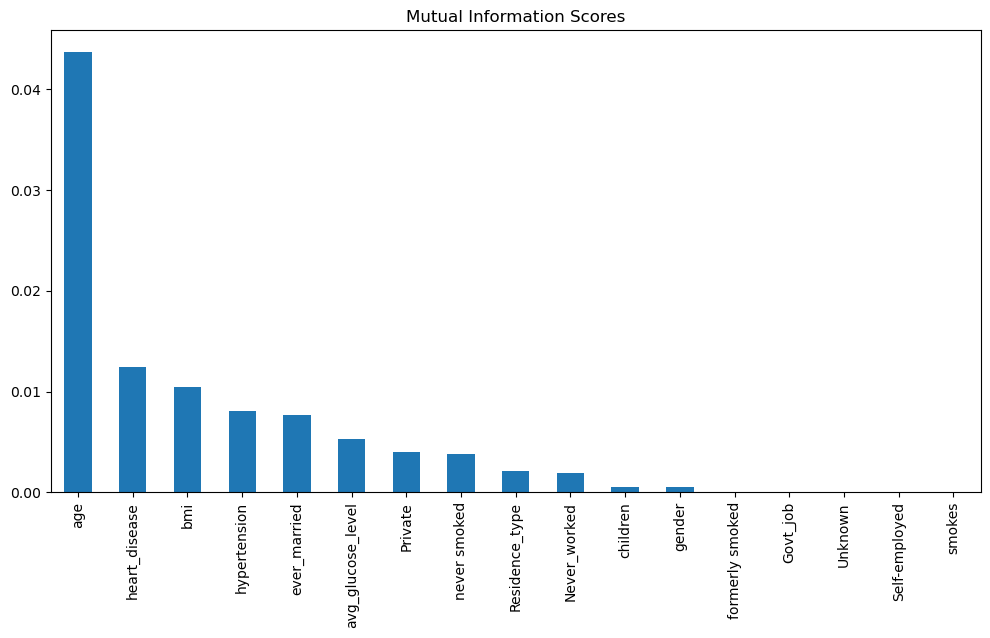

In [1272]:
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_scores)
mi_scores.plot(kind='bar', figsize=(12, 6), title='Mutual Information Scores')

#### Lasso - Least Absolute Shrinkage and Selection Operator 

In [1273]:
lasso_pipeline = Pipeline_lasso([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01, random_state=42))
])

lasso_pipeline.fit(X, y)
lasso_coefficients = pd.Series(
    lasso_pipeline.named_steps['lasso'].coef_,
    index=X.columns
).sort_values(ascending=False)

print("Lasso Selected Features:", lasso_coefficients[lasso_coefficients != 0].index.tolist())

Lasso Selected Features: ['age', 'heart_disease', 'avg_glucose_level', 'hypertension']


# Important features 
#### Blow are the aggregated important features from all the approaches described above.
#### ['age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi', 'private','never_smoked']

In [1274]:
important_features = ['age','hypertension','heart_disease','ever_married','avg_glucose_level','stroke','bmi', 'Private', 'never smoked']

In [1275]:
df_scaled_selection = df_scaled[important_features]

In [1276]:
df_scaled_selection

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0     0.816895           0.0            1.0           1.0           0.801265   
1     0.743652           0.0            0.0           1.0           0.679023   
2     0.975586           0.0            1.0           1.0           0.234512   
3     0.597168           0.0            0.0           1.0           0.536008   
4     0.963379           1.0            0.0           1.0           0.549349   
...        ...           ...            ...           ...                ...   
5104  0.975586           1.0            0.0           1.0           0.132167   
5105  0.987793           0.0            0.0           1.0           0.323516   
5106  0.426270           0.0            0.0           1.0           0.128658   
5107  0.621582           0.0            0.0           1.0           0.513203   
5108  0.536133           0.0            0.0           1.0           0.139230   

      stroke       bmi  Private  never smoked  
0        1.0  0.301260      1.0           0.0  
1        1.0  0.224278      0.0           1.0  
2        1.0  0.254296      1.0           1.0  
3        1.0  0.276060      1.0           0.0  
4        1.0  0.156930      0.0           1.0  
...      ...       ...      ...           ...  
5104     0.0  0.208212      1.0           1.0  
5105     0.0  0.340206      0.0           1.0  
5106     0.0  0.232532      0.0           1.0  
5107     0.0  0.175258      1.0           0.0  
5108     0.0  0.182131      0.0           0.0  

[5109 rows x 9 columns]

In [1277]:
X = df_scaled_selection.drop(columns=['stroke'])
y = df_scaled_selection['stroke']

In [1278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression

In [1279]:
lr_model_selection = LogisticRegression(random_state=42,max_iter=1000)

In [1280]:
lr_model_selection.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [1281]:
y_test_predicted_scaled_lr_selection = lr_model_selection.predict(X_test)

In [1282]:
(y_test_predicted_scaled_lr_selection == y_test).sum()/len(y_test)

0.9510763209393346

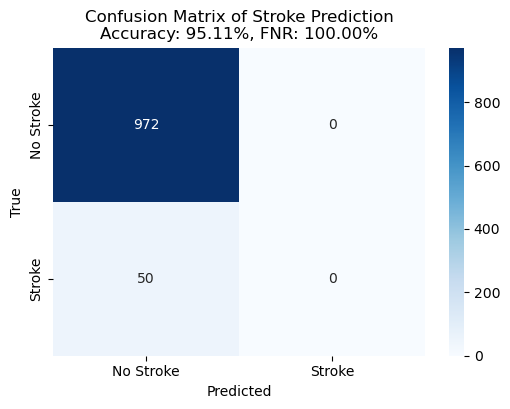

In [1283]:
conf_mat(y_test,y_test_predicted_scaled_lr_selection)

In [1284]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted_scaled_lr_selection)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1285]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### Multi-layer Perceptron Classifier

In [1286]:
nn_model_selection = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [1287]:
nn_model_selection.fit(X=X_train,y=y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [1288]:
y_test_predicted_nn_scaled_selection = nn_model_selection.predict(X_test)

In [1289]:
(y_test_predicted_nn_scaled_selection == y_test).sum()/len(y_test)

0.9510763209393346

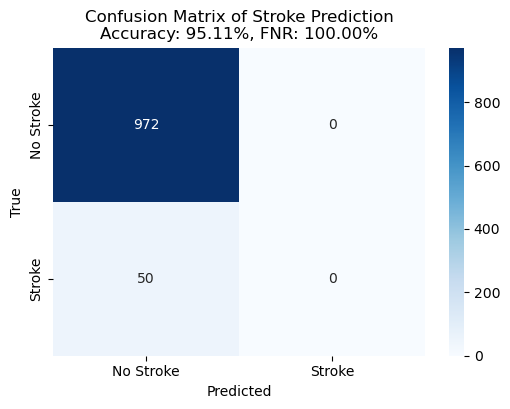

In [1290]:
conf_mat(y_test,y_test_predicted_nn_scaled_selection)

In [1291]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted_nn_scaled_selection)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1292]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### Decision Tree Classifier

In [1293]:
dt_model_selection = DecisionTreeClassifier(**decision_tree_params)

In [1294]:
dt_model_selection.fit(X=X_train, y=y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [1295]:
y_test_predicted_dt_scaled_selection = dt_model_selection.predict(X_test)

In [1296]:
(y_test_predicted_dt_scaled_selection == y_test).sum()/len(y_test)

0.9510763209393346

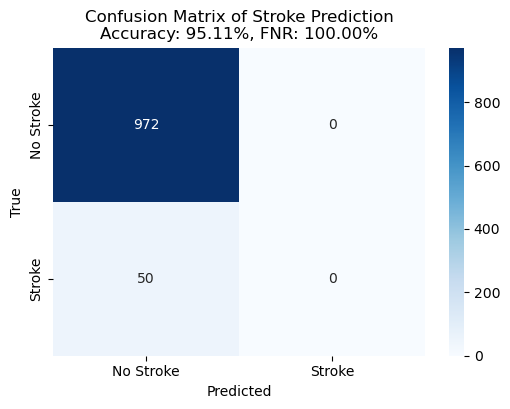

In [1297]:
conf_mat(y_test,y_test_predicted_dt_scaled_selection)

In [1298]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted_dt_scaled_selection)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1299]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### Random Forest Model

In [1300]:
rf_model_selection = RandomForestClassifier(**random_forest_params)

In [1301]:
rf_model_selection.fit(X=X_train,y=y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [1302]:
y_test_predicted_rf_scaled_selection = rf_model_selection.predict(X_test)

In [1303]:
(y_test_predicted_rf_scaled_selection == y_test).sum()/len(y_test)

0.9510763209393346

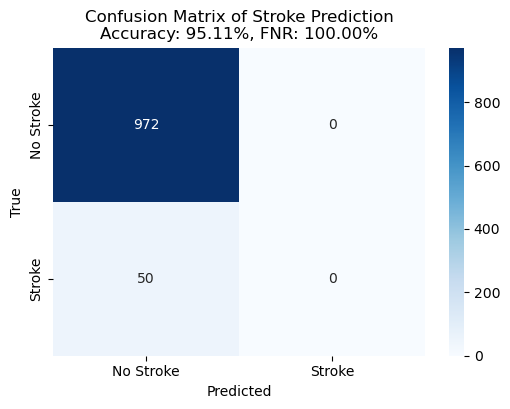

In [1304]:
conf_mat(y_test,y_test_predicted_rf_scaled_selection)

In [1305]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted_rf_scaled_selection)

C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aditya\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1306]:
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



### SMOTE - ALL Features

In [1307]:
df_scaled

gender       age  hypertension  heart_disease  ever_married  \
0        1.0  0.816895           0.0            1.0           1.0   
1        0.0  0.743652           0.0            0.0           1.0   
2        1.0  0.975586           0.0            1.0           1.0   
3        0.0  0.597168           0.0            0.0           1.0   
4        0.0  0.963379           1.0            0.0           1.0   
...      ...       ...           ...            ...           ...   
5104     0.0  0.975586           1.0            0.0           1.0   
5105     0.0  0.987793           0.0            0.0           1.0   
5106     0.0  0.426270           0.0            0.0           1.0   
5107     1.0  0.621582           0.0            0.0           1.0   
5108     0.0  0.536133           0.0            0.0           1.0   

      Residence_type  avg_glucose_level       bmi  stroke  Govt_job  \
0                1.0           0.801265  0.301260     1.0       0.0   
1                0.0           0.679023  0.224278     1.0       0.0   
2                0.0           0.234512  0.254296     1.0       0.0   
3                1.0           0.536008  0.276060     1.0       0.0   
4                0.0           0.549349  0.156930     1.0       0.0   
...              ...                ...       ...     ...       ...   
5104             1.0           0.132167  0.208212     0.0       0.0   
5105             1.0           0.323516  0.340206     0.0       0.0   
5106             0.0           0.128658  0.232532     0.0       0.0   
5107             0.0           0.513203  0.175258     0.0       0.0   
5108             1.0           0.139230  0.182131     0.0       1.0   

      Never_worked  Private  Self-employed  children  Unknown  \
0              0.0      1.0            0.0       0.0      0.0   
1              0.0      0.0            1.0       0.0      0.0   
2              0.0      1.0            0.0       0.0      0.0   
3              0.0      1.0            0.0       0.0      0.0   
4              0.0      0.0            1.0       0.0      0.0   
...            ...      ...            ...       ...      ...   
5104           0.0      1.0            0.0       0.0      0.0   
5105           0.0      0.0            1.0       0.0      0.0   
5106           0.0      0.0            1.0       0.0      0.0   
5107           0.0      1.0            0.0       0.0      0.0   
5108           0.0      0.0            0.0       0.0      1.0   

      formerly smoked  never smoked  smokes  
0                 1.0           0.0     0.0  
1                 0.0           1.0     0.0  
2                 0.0           1.0     0.0  
3                 0.0           0.0     1.0  
4                 0.0           1.0     0.0  
...               ...           ...     ...  
5104              0.0           1.0     0.0  
5105              0.0           1.0     0.0  
5106              0.0           1.0     0.0  
5107              1.0           0.0     0.0  
5108              0.0           0.0     0.0  

[5109 rows x 18 columns]

In [1308]:
X = df_scaled.drop(columns=['stroke'])
y = df_scaled['stroke']

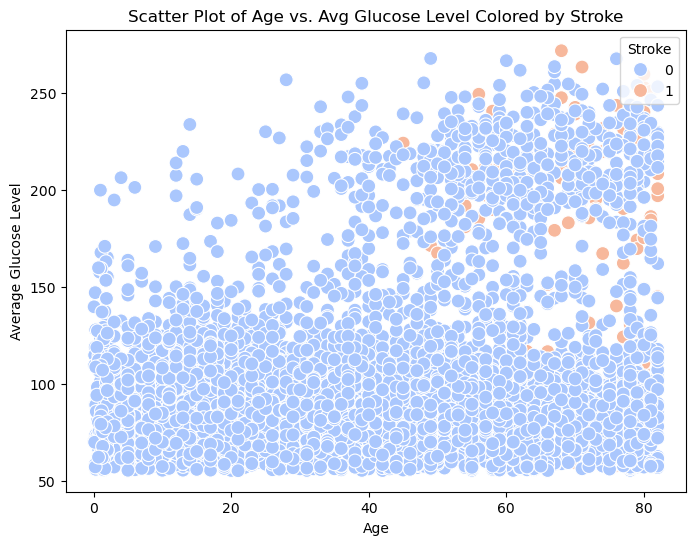

In [1309]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='age', y='avg_glucose_level', hue='stroke', palette='coolwarm', s=100)
plt.title('Scatter Plot of Age vs. Avg Glucose Level Colored by Stroke')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke', loc='upper right')
plt.show()

#### Supporting Instances for stroke before SMOTE

In [1310]:
test = Counter(y)
print(test)

Counter({0.0: 4860, 1.0: 249})


In [1311]:
oversample = SMOTE()

In [1312]:
X, y = oversample.fit_resample(X, y)

In [1313]:
X

gender       age  hypertension  heart_disease  ever_married  \
0        1.0  0.816895      0.000000            1.0           1.0   
1        0.0  0.743652      0.000000            0.0           1.0   
2        1.0  0.975586      0.000000            1.0           1.0   
3        0.0  0.597168      0.000000            0.0           1.0   
4        0.0  0.963379      1.000000            0.0           1.0   
...      ...       ...           ...            ...           ...   
9715     1.0  0.802508      0.000000            1.0           1.0   
9716     1.0  0.988252      0.000000            0.0           1.0   
9717     0.0  0.871409      0.000000            0.0           1.0   
9718     0.0  0.556490      0.393846            0.0           1.0   
9719     1.0  0.791015      0.268559            0.0           1.0   

      Residence_type  avg_glucose_level       bmi  Govt_job  Never_worked  \
0                1.0           0.801265  0.301260       0.0           0.0   
1                0.0           0.679023  0.224278       0.0           0.0   
2                0.0           0.234512  0.254296       0.0           0.0   
3                1.0           0.536008  0.276060       0.0           0.0   
4                0.0           0.549349  0.156930       0.0           0.0   
...              ...                ...       ...       ...           ...   
9715             1.0           0.388452  0.269601       0.0           0.0   
9716             0.0           0.142595  0.214212       0.0           0.0   
9717             1.0           0.677444  0.270350       1.0           0.0   
9718             0.0           0.137029  0.276884       0.0           0.0   
9719             0.0           0.509823  0.287584       0.0           0.0   

      Private  Self-employed  children  Unknown  formerly smoked  \
0         1.0            0.0       0.0      0.0              1.0   
1         0.0            1.0       0.0      0.0              0.0   
2         1.0            0.0       0.0      0.0              0.0   
3         1.0            0.0       0.0      0.0              0.0   
4         0.0            1.0       0.0      0.0              0.0   
...       ...            ...       ...      ...              ...   
9715      0.0            1.0       0.0      0.0              1.0   
9716      1.0            0.0       0.0      0.0              1.0   
9717      0.0            0.0       0.0      0.0              0.0   
9718      1.0            0.0       0.0      0.0              0.0   
9719      1.0            0.0       0.0      0.0              1.0   

      never smoked  smokes  
0              0.0     0.0  
1              1.0     0.0  
2              1.0     0.0  
3              0.0     1.0  
4              1.0     0.0  
...            ...     ...  
9715           0.0     0.0  
9716           0.0     0.0  
9717           1.0     0.0  
9718           0.0     1.0  
9719           0.0     0.0  

[9720 rows x 17 columns]

#### Supporting Instances for stroke after SMOTE

In [1314]:
counter = Counter(y)
print(counter)

Counter({1.0: 4860, 0.0: 4860})


In [1315]:
y_df = pd.DataFrame(y, columns=['stroke'])

In [1316]:
df_combined_all_features = pd.concat([X, y_df], axis=1)

In [1317]:
df_combined_all_features.nunique()

gender                475
age                  4548
hypertension          578
heart_disease         499
ever_married          428
Residence_type        652
avg_glucose_level    8589
bmi                  5128
Govt_job              136
Never_worked            2
Private               156
Self-employed          95
children               31
Unknown                82
formerly smoked        78
never smoked           35
smokes                 85
stroke                  2
dtype: int64

In [1318]:
binary_columns = [
    'gender', 
    'hypertension',
    'heart_disease', 
    'ever_married',
    'Residence_type',
    'Govt_job',
    'Private',
    'Self-employed',
    'children',
    'Unknown',
    'formerly smoked',
    'never smoked',
    'smokes',
]
    
for col in binary_columns:
    df_combined_all_features[col] = (df_combined_all_features[col] >= 0.5).astype(int)

In [1319]:
df_combined_all_features

gender       age  hypertension  heart_disease  ever_married  \
0          1  0.816895             0              1             1   
1          0  0.743652             0              0             1   
2          1  0.975586             0              1             1   
3          0  0.597168             0              0             1   
4          0  0.963379             1              0             1   
...      ...       ...           ...            ...           ...   
9715       1  0.802508             0              1             1   
9716       1  0.988252             0              0             1   
9717       0  0.871409             0              0             1   
9718       0  0.556490             0              0             1   
9719       1  0.791015             0              0             1   

      Residence_type  avg_glucose_level       bmi  Govt_job  Never_worked  \
0                  1           0.801265  0.301260         0           0.0   
1                  0           0.679023  0.224278         0           0.0   
2                  0           0.234512  0.254296         0           0.0   
3                  1           0.536008  0.276060         0           0.0   
4                  0           0.549349  0.156930         0           0.0   
...              ...                ...       ...       ...           ...   
9715               1           0.388452  0.269601         0           0.0   
9716               0           0.142595  0.214212         0           0.0   
9717               1           0.677444  0.270350         1           0.0   
9718               0           0.137029  0.276884         0           0.0   
9719               0           0.509823  0.287584         0           0.0   

      Private  Self-employed  children  Unknown  formerly smoked  \
0           1              0         0        0                1   
1           0              1         0        0                0   
2           1              0         0        0                0   
3           1              0         0        0                0   
4           0              1         0        0                0   
...       ...            ...       ...      ...              ...   
9715        0              1         0        0                1   
9716        1              0         0        0                1   
9717        0              0         0        0                0   
9718        1              0         0        0                0   
9719        1              0         0        0                1   

      never smoked  smokes  stroke  
0                0       0     1.0  
1                1       0     1.0  
2                1       0     1.0  
3                0       1     1.0  
4                1       0     1.0  
...            ...     ...     ...  
9715             0       0     1.0  
9716             0       0     1.0  
9717             1       0     1.0  
9718             0       1     1.0  
9719             0       0     1.0  

[9720 rows x 18 columns]

In [1320]:
df_combined_all_features.nunique()

gender                  2
age                  4548
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
avg_glucose_level    8589
bmi                  5128
Govt_job                2
Never_worked            2
Private                 2
Self-employed           2
children                2
Unknown                 2
formerly smoked         2
never smoked            2
smokes                  2
stroke                  2
dtype: int64

In [1321]:
X = df_combined_all_features.drop(columns=['stroke'])
y = df_combined_all_features['stroke']

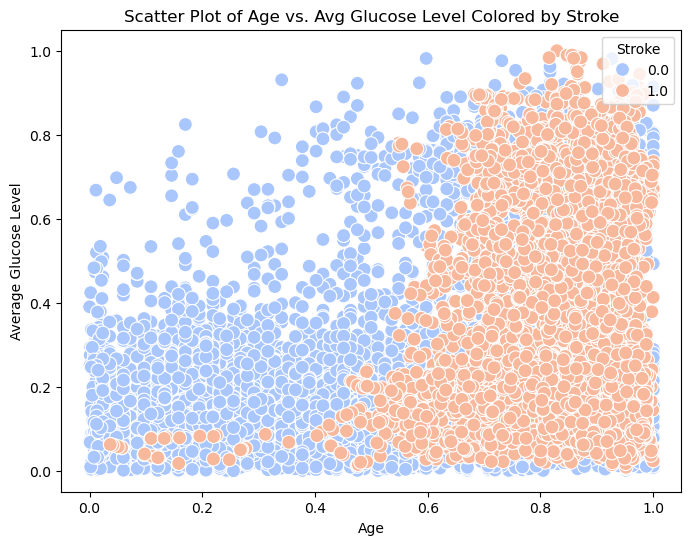

In [1322]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_combined_all_features, x='age', y='avg_glucose_level', hue='stroke', palette='coolwarm', s=100)
plt.title('Scatter Plot of Age vs. Avg Glucose Level Colored by Stroke')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke', loc='upper right')
plt.show()

In [1323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression

In [1324]:
lr_model_smote = LogisticRegression(random_state=42,max_iter=1000)

In [1325]:
lr_model_smote.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [1326]:
y_test_predicted_smote = lr_model_smote.predict(X_test)

In [1327]:
(y_test_predicted_smote == y_test).sum()/len(y_test)

0.7942386831275721

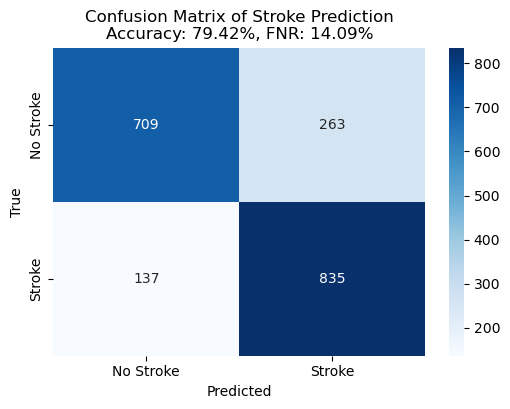

In [1328]:
conf_mat(y_test,y_test_predicted_smote)

In [1329]:
report_rf = classification_report(y_pred=y_test_predicted_smote,y_true=y_test)

In [1330]:
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.84      0.73      0.78       972
         1.0       0.76      0.86      0.81       972

    accuracy                           0.79      1944
   macro avg       0.80      0.79      0.79      1944
weighted avg       0.80      0.79      0.79      1944



### Cross Validation

In [1331]:
cv = StratifiedKFold(n_splits=7)

In [1332]:
scores = cross_val_score(lr_model_smote, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [1333]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.77609791 0.79049676 0.78905688 0.79049676 0.78097983 0.79827089
 0.79971182]
Mean accuracy: 0.7893015491654863


### Multi-layer Perceptron Classifier

In [1334]:
nn_model_smote = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [1335]:
nn_model_smote.fit(X=X_train,y=y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [1336]:
y_test_predicted_nn_smote = nn_model_smote.predict(X_test)

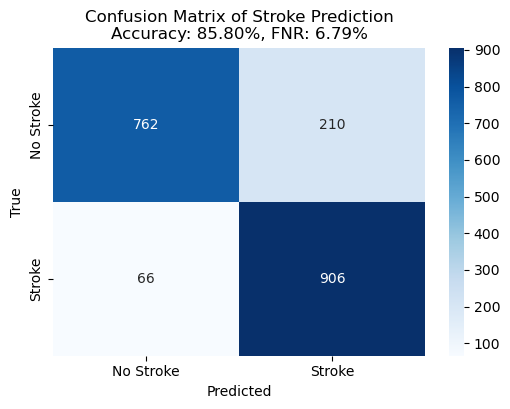

In [1337]:
conf_mat(y_test,y_test_predicted_nn_smote)

In [1338]:
report_rf = classification_report(y_pred=y_test_predicted_nn_smote,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.92      0.78      0.85       972
         1.0       0.81      0.93      0.87       972

    accuracy                           0.86      1944
   macro avg       0.87      0.86      0.86      1944
weighted avg       0.87      0.86      0.86      1944



In [1339]:
scores = cross_val_score(nn_model_smote, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [1340]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.8488121  0.85169186 0.86177106 0.87185025 0.86887608 0.88040346
 0.85446686]
Mean accuracy: 0.8625530953818467


#### Decision Tree Classifier

In [1341]:
dt_model_smote = DecisionTreeClassifier(**decision_tree_params)

In [1342]:
dt_model_smote.fit(X=X_train,y=y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [1343]:
y_test_predicted_dt_smote = dt_model_smote.predict(X_test)

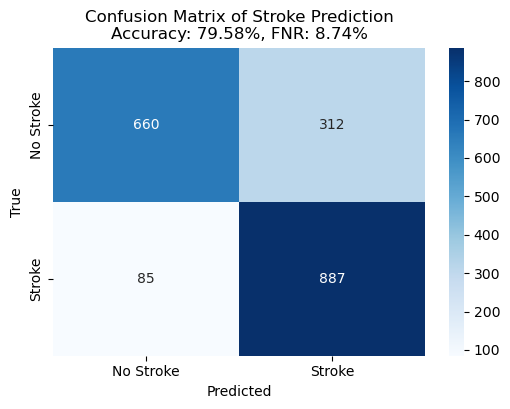

In [1344]:
conf_mat(y_test,y_test_predicted_dt_smote)

In [1345]:
scores = cross_val_score(dt_model_smote, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [1346]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.77609791 0.78977682 0.78833693 0.78617711 0.78170029 0.79899135
 0.79971182]
Mean accuracy: 0.7886846038731062


In [1347]:
report_rf = classification_report(y_pred=y_test_predicted_dt_smote,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77       972
         1.0       0.74      0.91      0.82       972

    accuracy                           0.80      1944
   macro avg       0.81      0.80      0.79      1944
weighted avg       0.81      0.80      0.79      1944



#### Random Forest Classifier

In [1348]:
rf_model_smote = RandomForestClassifier(**random_forest_params)

In [1349]:
rf_model_smote.fit(X=X_train,y=y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [1350]:
y_test_predicted_rf_smote = rf_model_smote.predict(X_test)

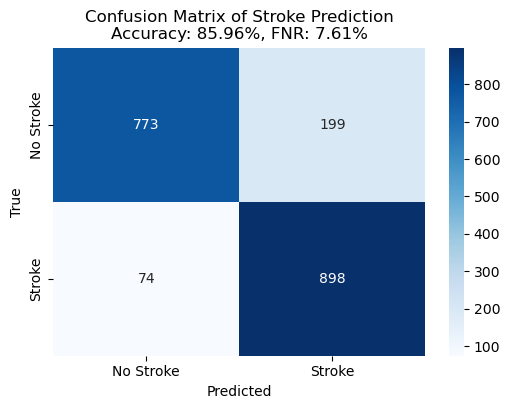

In [1351]:
conf_mat(y_test,y_test_predicted_rf_smote)

In [1352]:
scores = cross_val_score(rf_model_smote, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1353]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.93544876 0.94847304 0.94700309 0.94574669 0.95337143 0.95085916
 0.94991861]
Mean accuracy: 0.9472601092728169


In [1354]:
report_rf = classification_report(y_pred=y_test_predicted_rf_smote,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85       972
         1.0       0.82      0.92      0.87       972

    accuracy                           0.86      1944
   macro avg       0.87      0.86      0.86      1944
weighted avg       0.87      0.86      0.86      1944



## SMOTE-Selected Features

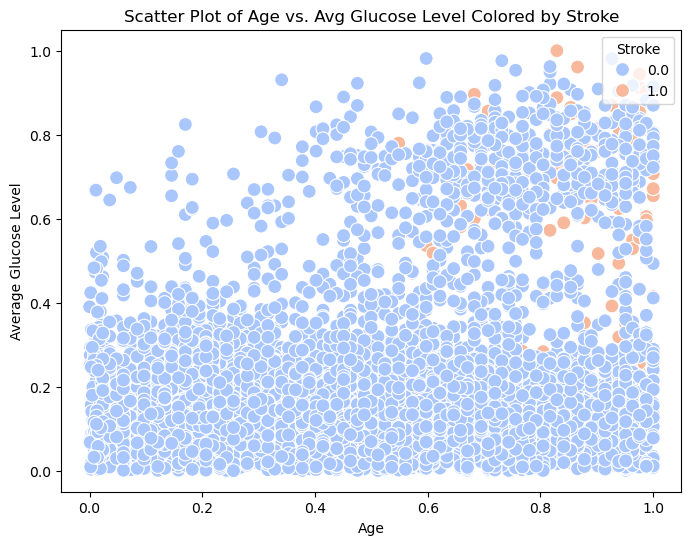

In [1013]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled_selection, x='age', y='avg_glucose_level', hue='stroke', palette='coolwarm', s=100)
plt.title('Scatter Plot of Age vs. Avg Glucose Level Colored by Stroke')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke', loc='upper right')
plt.show()

In [1014]:
X = df_scaled_selection.drop(columns=['stroke'])
y = df_scaled_selection['stroke']

#### Supporting Instances for stroke before SMOTE

In [1015]:
test = Counter(y)
print(test)

Counter({0.0: 4860, 1.0: 249})


In [1016]:
X

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0     0.816895           0.0            1.0           1.0           0.801265   
1     0.743652           0.0            0.0           1.0           0.679023   
2     0.975586           0.0            1.0           1.0           0.234512   
3     0.597168           0.0            0.0           1.0           0.536008   
4     0.963379           1.0            0.0           1.0           0.549349   
...        ...           ...            ...           ...                ...   
5104  0.975586           1.0            0.0           1.0           0.132167   
5105  0.987793           0.0            0.0           1.0           0.323516   
5106  0.426270           0.0            0.0           1.0           0.128658   
5107  0.621582           0.0            0.0           1.0           0.513203   
5108  0.536133           0.0            0.0           1.0           0.139230   

           bmi  Private  never smoked  
0     0.301260      1.0           0.0  
1     0.224278      0.0           1.0  
2     0.254296      1.0           1.0  
3     0.276060      1.0           0.0  
4     0.156930      0.0           1.0  
...        ...      ...           ...  
5104  0.208212      1.0           1.0  
5105  0.340206      0.0           1.0  
5106  0.232532      0.0           1.0  
5107  0.175258      1.0           0.0  
5108  0.182131      0.0           0.0  

[5109 rows x 8 columns]

In [1017]:
oversample = SMOTE()

In [1018]:
X, y = oversample.fit_resample(X, y)

#### Supporting Instances for stroke after SMOTE

In [1019]:
counter = Counter(y)
print(counter)

Counter({1.0: 4860, 0.0: 4860})


In [1020]:
y_df = pd.DataFrame(y, columns=['stroke'])

In [1021]:
df_combined_smote_selection = pd.concat([X, y_df], axis=1)

In [1022]:
df_combined_smote_selection

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0     0.816895           0.0            1.0      1.000000           0.801265   
1     0.743652           0.0            0.0      1.000000           0.679023   
2     0.975586           0.0            1.0      1.000000           0.234512   
3     0.597168           0.0            0.0      1.000000           0.536008   
4     0.963379           1.0            0.0      1.000000           0.549349   
...        ...           ...            ...           ...                ...   
9715  0.897263           0.0            1.0      0.492382           0.735477   
9716  0.948645           1.0            0.0      1.000000           0.255785   
9717  0.886860           0.0            0.0      1.000000           0.052617   
9718  0.967741           1.0            0.0      0.357316           0.149448   
9719  0.566628           1.0            0.0      1.000000           0.029003   

           bmi  Private  never smoked  stroke  
0     0.301260      1.0           0.0     1.0  
1     0.224278      0.0           1.0     1.0  
2     0.254296      1.0           1.0     1.0  
3     0.276060      1.0           0.0     1.0  
4     0.156930      0.0           1.0     1.0  
...        ...      ...           ...     ...  
9715  0.242190      1.0           0.0     1.0  
9716  0.234126      0.0           1.0     1.0  
9717  0.216061      0.0           1.0     1.0  
9718  0.153420      0.0           0.0     1.0  
9719  0.304719      1.0           0.0     1.0  

[9720 rows x 9 columns]

In [1023]:
df_combined_smote_selection.nunique()

age                  4458
hypertension           36
heart_disease          89
ever_married          174
avg_glucose_level    8589
bmi                  5120
Private                46
never smoked           11
stroke                  2
dtype: int64

In [1024]:
binary_columns = [
    'hypertension',
    'heart_disease', 
    'ever_married',
    'Private',
    'never smoked'
]
for col in binary_columns:
    df_combined_smote_selection[col] = (df_combined_smote_selection[col] >= 0.5).astype(int)

In [1025]:
df_combined_smote_selection

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0     0.816895             0              1             1           0.801265   
1     0.743652             0              0             1           0.679023   
2     0.975586             0              1             1           0.234512   
3     0.597168             0              0             1           0.536008   
4     0.963379             1              0             1           0.549349   
...        ...           ...            ...           ...                ...   
9715  0.897263             0              1             0           0.735477   
9716  0.948645             1              0             1           0.255785   
9717  0.886860             0              0             1           0.052617   
9718  0.967741             1              0             0           0.149448   
9719  0.566628             1              0             1           0.029003   

           bmi  Private  never smoked  stroke  
0     0.301260        1             0     1.0  
1     0.224278        0             1     1.0  
2     0.254296        1             1     1.0  
3     0.276060        1             0     1.0  
4     0.156930        0             1     1.0  
...        ...      ...           ...     ...  
9715  0.242190        1             0     1.0  
9716  0.234126        0             1     1.0  
9717  0.216061        0             1     1.0  
9718  0.153420        0             0     1.0  
9719  0.304719        1             0     1.0  

[9720 rows x 9 columns]

In [1026]:
df_combined_smote_selection.nunique()

age                  4458
hypertension            2
heart_disease           2
ever_married            2
avg_glucose_level    8589
bmi                  5120
Private                 2
never smoked            2
stroke                  2
dtype: int64

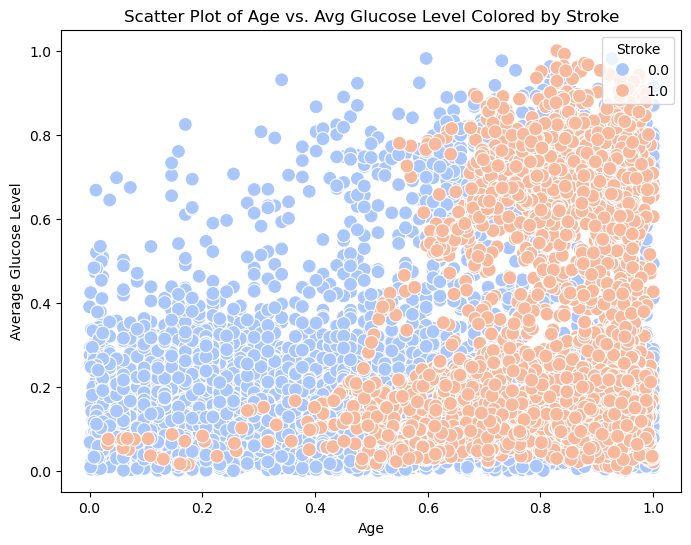

In [1027]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_combined_smote_selection, x='age', y='avg_glucose_level', hue='stroke', palette='coolwarm', s=100)
plt.title('Scatter Plot of Age vs. Avg Glucose Level Colored by Stroke')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke', loc='upper right')
plt.show()

In [1028]:
X = df_combined_smote_selection.drop(columns=['stroke'])
y = df_combined_smote_selection['stroke']

In [1029]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression

In [1030]:
lr_model_smote_selection = LogisticRegression(random_state=42,max_iter=1000)

In [1031]:
lr_model_smote_selection.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [1032]:
y_test_predicted_smote = lr_model_smote_selection.predict(X_test)

In [1033]:
(y_test_predicted_smote == y_test).sum()/len(y_test)

0.7813786008230452

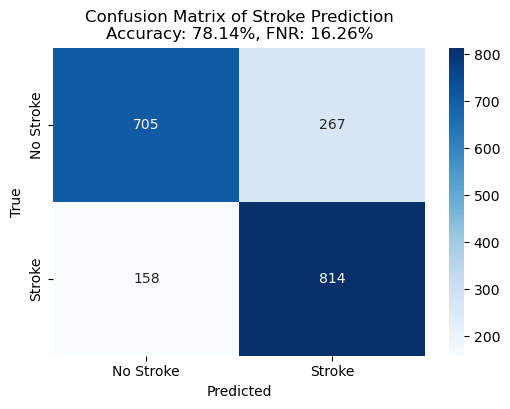

In [1034]:
conf_mat(y_test,y_test_predicted_smote)

In [1035]:
scores = cross_val_score(lr_model_smote_selection, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1036]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.85434661 0.84001202 0.8627786  0.83923662 0.8322696  0.87008031
 0.84739305]
Mean accuracy: 0.8494452587629194


In [1037]:
report_rf = classification_report(y_pred=y_test_predicted_smote,y_true=y_test)

In [1038]:
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       972
         1.0       0.75      0.84      0.79       972

    accuracy                           0.78      1944
   macro avg       0.78      0.78      0.78      1944
weighted avg       0.78      0.78      0.78      1944



#### Multi-layer Perceptron Classifier

In [1039]:
nn_model_smote_selection = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [1040]:
nn_model_smote_selection.fit(X=X_train,y=y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [1041]:
y_test_predicted_nn_smote_selection = nn_model_smote_selection.predict(X_test)

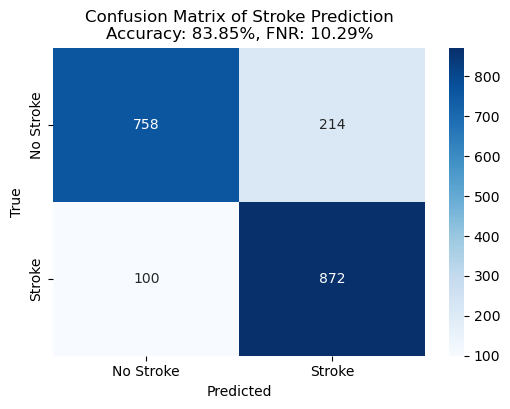

In [1042]:
conf_mat(y_test,y_test_predicted_nn_smote_selection)

In [1043]:
scores = cross_val_score(nn_model_smote_selection, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [1044]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.82937365 0.80849532 0.82433405 0.82217423 0.82708934 0.82348703
 0.82708934]
Mean accuracy: 0.8231489936959838


In [1045]:
report_rf = classification_report(y_pred=y_test_predicted_nn_smote_selection,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       972
         1.0       0.80      0.90      0.85       972

    accuracy                           0.84      1944
   macro avg       0.84      0.84      0.84      1944
weighted avg       0.84      0.84      0.84      1944



#### Decision Tree Classifier

In [1046]:
dt_model_smote_selection = DecisionTreeClassifier(**decision_tree_params)

In [1047]:
dt_model_smote_selection.fit(X=X_train,y=y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [1048]:
y_test_predicted_dt_smote_selection = dt_model_smote_selection.predict(X_test)

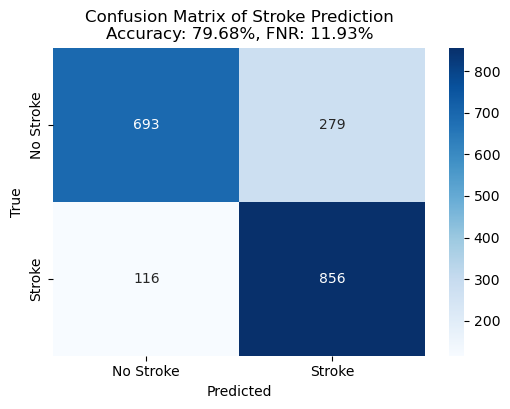

In [1049]:
conf_mat(y_test,y_test_predicted_dt_smote_selection)

In [1050]:
scores = cross_val_score(dt_model_smote_selection, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [1051]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.78833693 0.77969762 0.79481641 0.77465803 0.77737752 0.80043228
 0.78746398]
Mean accuracy: 0.7861118249280281


In [1052]:
report_rf = classification_report(y_pred=y_test_predicted_dt_smote_selection,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78       972
         1.0       0.75      0.88      0.81       972

    accuracy                           0.80      1944
   macro avg       0.81      0.80      0.80      1944
weighted avg       0.81      0.80      0.80      1944



#### Random Forest Classifier

In [1053]:
rf_model_smote_selection = RandomForestClassifier(**random_forest_params)

In [1054]:
rf_model_smote_selection.fit(X=X_train,y=y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [1055]:
y_test_predicted_rf_smote_selection = rf_model_smote_selection.predict(X_test)

In [1056]:
(y_test_predicted_rf_smote_selection == y_test).sum()/len(y_test)

0.8719135802469136

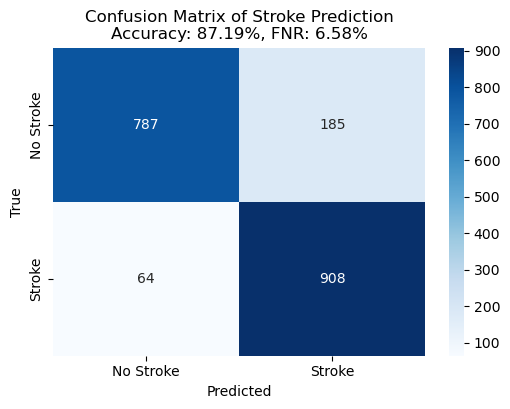

In [1057]:
conf_mat(y_test,y_test_predicted_rf_smote_selection)

In [1058]:
scores = cross_val_score(rf_model_smote_selection, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1059]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.9402546  0.9431012  0.94730993 0.93839902 0.94109452 0.95567192
 0.93988614]
Mean accuracy: 0.9436739034293675


In [1060]:
report_rf = classification_report(y_pred=y_test_predicted_rf_smote_selection,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86       972
         1.0       0.83      0.93      0.88       972

    accuracy                           0.87      1944
   macro avg       0.88      0.87      0.87      1944
weighted avg       0.88      0.87      0.87      1944



### Undersample SMOTE

### All Features

In [1061]:
df_scaled

gender       age  hypertension  heart_disease  ever_married  \
0        1.0  0.816895           0.0            1.0           1.0   
1        0.0  0.743652           0.0            0.0           1.0   
2        1.0  0.975586           0.0            1.0           1.0   
3        0.0  0.597168           0.0            0.0           1.0   
4        0.0  0.963379           1.0            0.0           1.0   
...      ...       ...           ...            ...           ...   
5104     0.0  0.975586           1.0            0.0           1.0   
5105     0.0  0.987793           0.0            0.0           1.0   
5106     0.0  0.426270           0.0            0.0           1.0   
5107     1.0  0.621582           0.0            0.0           1.0   
5108     0.0  0.536133           0.0            0.0           1.0   

      Residence_type  avg_glucose_level       bmi  stroke  Govt_job  \
0                1.0           0.801265  0.301260     1.0       0.0   
1                0.0           0.679023  0.224278     1.0       0.0   
2                0.0           0.234512  0.254296     1.0       0.0   
3                1.0           0.536008  0.276060     1.0       0.0   
4                0.0           0.549349  0.156930     1.0       0.0   
...              ...                ...       ...     ...       ...   
5104             1.0           0.132167  0.208212     0.0       0.0   
5105             1.0           0.323516  0.340206     0.0       0.0   
5106             0.0           0.128658  0.232532     0.0       0.0   
5107             0.0           0.513203  0.175258     0.0       0.0   
5108             1.0           0.139230  0.182131     0.0       1.0   

      Never_worked  Private  Self-employed  children  Unknown  \
0              0.0      1.0            0.0       0.0      0.0   
1              0.0      0.0            1.0       0.0      0.0   
2              0.0      1.0            0.0       0.0      0.0   
3              0.0      1.0            0.0       0.0      0.0   
4              0.0      0.0            1.0       0.0      0.0   
...            ...      ...            ...       ...      ...   
5104           0.0      1.0            0.0       0.0      0.0   
5105           0.0      0.0            1.0       0.0      0.0   
5106           0.0      0.0            1.0       0.0      0.0   
5107           0.0      1.0            0.0       0.0      0.0   
5108           0.0      0.0            0.0       0.0      1.0   

      formerly smoked  never smoked  smokes  
0                 1.0           0.0     0.0  
1                 0.0           1.0     0.0  
2                 0.0           1.0     0.0  
3                 0.0           0.0     1.0  
4                 0.0           1.0     0.0  
...               ...           ...     ...  
5104              0.0           1.0     0.0  
5105              0.0           1.0     0.0  
5106              0.0           1.0     0.0  
5107              1.0           0.0     0.0  
5108              0.0           0.0     0.0  

[5109 rows x 18 columns]

In [1062]:
X_all = df_scaled.drop(columns=['stroke'])
y_all = df_scaled['stroke']

In [1063]:
X_all

gender       age  hypertension  heart_disease  ever_married  \
0        1.0  0.816895           0.0            1.0           1.0   
1        0.0  0.743652           0.0            0.0           1.0   
2        1.0  0.975586           0.0            1.0           1.0   
3        0.0  0.597168           0.0            0.0           1.0   
4        0.0  0.963379           1.0            0.0           1.0   
...      ...       ...           ...            ...           ...   
5104     0.0  0.975586           1.0            0.0           1.0   
5105     0.0  0.987793           0.0            0.0           1.0   
5106     0.0  0.426270           0.0            0.0           1.0   
5107     1.0  0.621582           0.0            0.0           1.0   
5108     0.0  0.536133           0.0            0.0           1.0   

      Residence_type  avg_glucose_level       bmi  Govt_job  Never_worked  \
0                1.0           0.801265  0.301260       0.0           0.0   
1                0.0           0.679023  0.224278       0.0           0.0   
2                0.0           0.234512  0.254296       0.0           0.0   
3                1.0           0.536008  0.276060       0.0           0.0   
4                0.0           0.549349  0.156930       0.0           0.0   
...              ...                ...       ...       ...           ...   
5104             1.0           0.132167  0.208212       0.0           0.0   
5105             1.0           0.323516  0.340206       0.0           0.0   
5106             0.0           0.128658  0.232532       0.0           0.0   
5107             0.0           0.513203  0.175258       0.0           0.0   
5108             1.0           0.139230  0.182131       1.0           0.0   

      Private  Self-employed  children  Unknown  formerly smoked  \
0         1.0            0.0       0.0      0.0              1.0   
1         0.0            1.0       0.0      0.0              0.0   
2         1.0            0.0       0.0      0.0              0.0   
3         1.0            0.0       0.0      0.0              0.0   
4         0.0            1.0       0.0      0.0              0.0   
...       ...            ...       ...      ...              ...   
5104      1.0            0.0       0.0      0.0              0.0   
5105      0.0            1.0       0.0      0.0              0.0   
5106      0.0            1.0       0.0      0.0              0.0   
5107      1.0            0.0       0.0      0.0              1.0   
5108      0.0            0.0       0.0      1.0              0.0   

      never smoked  smokes  
0              0.0     0.0  
1              1.0     0.0  
2              1.0     0.0  
3              0.0     1.0  
4              1.0     0.0  
...            ...     ...  
5104           1.0     0.0  
5105           1.0     0.0  
5106           1.0     0.0  
5107           0.0     0.0  
5108           0.0     0.0  

[5109 rows x 17 columns]

In [1064]:
k = 7

In [1065]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=k)

In [1066]:
under = RandomUnderSampler(sampling_strategy=0.5)

In [1067]:
steps = [('over', over), ('under', under)]

In [1068]:
pipeline = Pipeline(steps=steps)

In [1069]:
X, y = pipeline.fit_resample(X_all, y_all)

In [1070]:
X

gender       age  hypertension  heart_disease  ever_married  \
555   0.000000  0.670410           0.0       0.000000           0.0   
3417  0.000000  0.291992           0.0       0.000000           0.0   
3487  0.000000  0.133301           0.0       0.000000           0.0   
2636  0.000000  0.902344           0.0       0.000000           1.0   
1668  0.000000  0.096680           0.0       0.000000           0.0   
...        ...       ...           ...            ...           ...   
5341  0.660597  0.963157           0.0       0.000000           1.0   
5342  0.000000  0.947552           0.0       0.351732           1.0   
5343  0.000000  0.918345           0.0       0.000000           1.0   
5344  1.000000  0.816812           0.0       1.000000           1.0   
5345  0.000000  0.964732           1.0       0.000000           1.0   

      Residence_type  avg_glucose_level       bmi  Govt_job  Never_worked  \
555         0.000000           0.176530  0.207331       0.0           0.0   
3417        0.000000           0.482781  0.176403       0.0           0.0   
3487        1.000000           0.240329  0.198167       0.0           0.0   
2636        1.000000           0.281230  0.235968       0.0           0.0   
1668        0.000000           0.076216  0.068729       0.0           0.0   
...              ...                ...       ...       ...           ...   
5341        0.000000           0.204079  0.184249       0.0           0.0   
5342        1.000000           0.428986  0.232279       0.0           0.0   
5343        0.310807           0.676721  0.216262       0.0           0.0   
5344        1.000000           0.730581  0.218848       0.0           0.0   
5345        0.000000           0.523748  0.157565       0.0           0.0   

      Private  Self-employed  children  Unknown  formerly smoked  \
555       1.0            0.0       0.0      0.0              0.0   
3417      1.0            0.0       0.0      1.0              0.0   
3487      0.0            0.0       1.0      1.0              0.0   
2636      1.0            0.0       0.0      0.0              0.0   
1668      0.0            0.0       1.0      1.0              0.0   
...       ...            ...       ...      ...              ...   
5341      0.0            1.0       0.0      0.0              0.0   
5342      1.0            0.0       0.0      0.0              0.0   
5343      1.0            0.0       0.0      1.0              0.0   
5344      1.0            0.0       0.0      1.0              0.0   
5345      0.0            1.0       0.0      0.0              0.0   

      never smoked  smokes  
555            1.0     0.0  
3417           0.0     0.0  
3487           0.0     0.0  
2636           1.0     0.0  
1668           0.0     0.0  
...            ...     ...  
5341           1.0     0.0  
5342           1.0     0.0  
5343           0.0     0.0  
5344           0.0     0.0  
5345           1.0     0.0  

[1458 rows x 17 columns]

In [1071]:
counter = Counter(y)
print(counter)

Counter({0.0: 972, 1.0: 486})


In [1072]:
y_df = pd.DataFrame(y, columns=['stroke'])

In [1073]:
df_combined_undersample = pd.concat([X, y_df], axis=1)

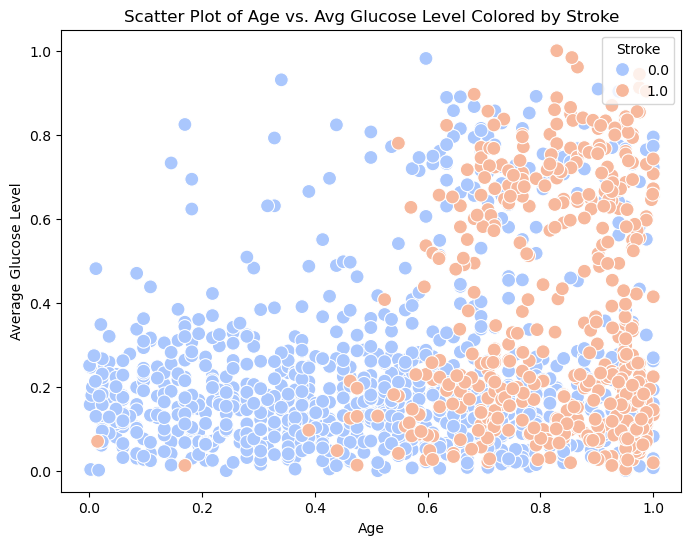

In [1074]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_combined_undersample, x='age', y='avg_glucose_level', hue='stroke', palette='coolwarm', s=100)
plt.title('Scatter Plot of Age vs. Avg Glucose Level Colored by Stroke')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke', loc='upper right')
plt.show()


In [1075]:
df_combined_undersample

gender       age  hypertension  heart_disease  ever_married  \
555   0.000000  0.670410           0.0       0.000000           0.0   
3417  0.000000  0.291992           0.0       0.000000           0.0   
3487  0.000000  0.133301           0.0       0.000000           0.0   
2636  0.000000  0.902344           0.0       0.000000           1.0   
1668  0.000000  0.096680           0.0       0.000000           0.0   
...        ...       ...           ...            ...           ...   
5341  0.660597  0.963157           0.0       0.000000           1.0   
5342  0.000000  0.947552           0.0       0.351732           1.0   
5343  0.000000  0.918345           0.0       0.000000           1.0   
5344  1.000000  0.816812           0.0       1.000000           1.0   
5345  0.000000  0.964732           1.0       0.000000           1.0   

      Residence_type  avg_glucose_level       bmi  Govt_job  Never_worked  \
555         0.000000           0.176530  0.207331       0.0           0.0   
3417        0.000000           0.482781  0.176403       0.0           0.0   
3487        1.000000           0.240329  0.198167       0.0           0.0   
2636        1.000000           0.281230  0.235968       0.0           0.0   
1668        0.000000           0.076216  0.068729       0.0           0.0   
...              ...                ...       ...       ...           ...   
5341        0.000000           0.204079  0.184249       0.0           0.0   
5342        1.000000           0.428986  0.232279       0.0           0.0   
5343        0.310807           0.676721  0.216262       0.0           0.0   
5344        1.000000           0.730581  0.218848       0.0           0.0   
5345        0.000000           0.523748  0.157565       0.0           0.0   

      Private  Self-employed  children  Unknown  formerly smoked  \
555       1.0            0.0       0.0      0.0              0.0   
3417      1.0            0.0       0.0      1.0              0.0   
3487      0.0            0.0       1.0      1.0              0.0   
2636      1.0            0.0       0.0      0.0              0.0   
1668      0.0            0.0       1.0      1.0              0.0   
...       ...            ...       ...      ...              ...   
5341      0.0            1.0       0.0      0.0              0.0   
5342      1.0            0.0       0.0      0.0              0.0   
5343      1.0            0.0       0.0      1.0              0.0   
5344      1.0            0.0       0.0      1.0              0.0   
5345      0.0            1.0       0.0      0.0              0.0   

      never smoked  smokes  stroke  
555            1.0     0.0     0.0  
3417           0.0     0.0     0.0  
3487           0.0     0.0     0.0  
2636           1.0     0.0     0.0  
1668           0.0     0.0     0.0  
...            ...     ...     ...  
5341           1.0     0.0     1.0  
5342           1.0     0.0     1.0  
5343           0.0     0.0     1.0  
5344           0.0     0.0     1.0  
5345           1.0     0.0     1.0  

[1458 rows x 18 columns]

In [1076]:
binary_columns = [
    'gender', 
    'hypertension',
    'heart_disease', 
    'ever_married',
    'Residence_type',
    'Govt_job',
    'Private',
    'Self-employed',
    'children',
    'Unknown',
    'formerly smoked',
    'never smoked',
    'smokes',
]
    
for col in binary_columns:
    df_combined_undersample[col] = (df_combined_undersample[col] >= 0.5).astype(int)

In [1077]:
df_combined_undersample

gender       age  hypertension  heart_disease  ever_married  \
555        0  0.670410             0              0             0   
3417       0  0.291992             0              0             0   
3487       0  0.133301             0              0             0   
2636       0  0.902344             0              0             1   
1668       0  0.096680             0              0             0   
...      ...       ...           ...            ...           ...   
5341       1  0.963157             0              0             1   
5342       0  0.947552             0              0             1   
5343       0  0.918345             0              0             1   
5344       1  0.816812             0              1             1   
5345       0  0.964732             1              0             1   

      Residence_type  avg_glucose_level       bmi  Govt_job  Never_worked  \
555                0           0.176530  0.207331         0           0.0   
3417               0           0.482781  0.176403         0           0.0   
3487               1           0.240329  0.198167         0           0.0   
2636               1           0.281230  0.235968         0           0.0   
1668               0           0.076216  0.068729         0           0.0   
...              ...                ...       ...       ...           ...   
5341               0           0.204079  0.184249         0           0.0   
5342               1           0.428986  0.232279         0           0.0   
5343               0           0.676721  0.216262         0           0.0   
5344               1           0.730581  0.218848         0           0.0   
5345               0           0.523748  0.157565         0           0.0   

      Private  Self-employed  children  Unknown  formerly smoked  \
555         1              0         0        0                0   
3417        1              0         0        1                0   
3487        0              0         1        1                0   
2636        1              0         0        0                0   
1668        0              0         1        1                0   
...       ...            ...       ...      ...              ...   
5341        0              1         0        0                0   
5342        1              0         0        0                0   
5343        1              0         0        1                0   
5344        1              0         0        1                0   
5345        0              1         0        0                0   

      never smoked  smokes  stroke  
555              1       0     0.0  
3417             0       0     0.0  
3487             0       0     0.0  
2636             1       0     0.0  
1668             0       0     0.0  
...            ...     ...     ...  
5341             1       0     1.0  
5342             1       0     1.0  
5343             0       0     1.0  
5344             0       0     1.0  
5345             1       0     1.0  

[1458 rows x 18 columns]

In [1078]:
X = df_combined_undersample.drop(columns=['stroke'])
y = df_combined_undersample['stroke']

In [1079]:
counter = Counter(y)
print(counter)

Counter({0.0: 972, 1.0: 486})


In [1080]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression Classifier

In [1081]:
lr_model_smote_und = LogisticRegression(random_state=42,max_iter=1000)

In [1082]:
lr_model_smote_und.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [1083]:
y_test_predicted_smote_under_lr = lr_model_smote_und.predict(X_test)

In [1084]:
(y_test_predicted_smote_under_lr == y_test).sum()/len(y_test)

0.7945205479452054

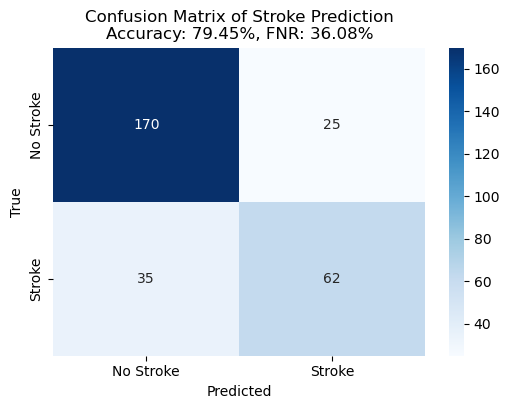

In [1085]:
conf_mat(y_test,y_test_predicted_smote_under_lr)

In [1086]:
scores = cross_val_score(lr_model_smote_und, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1087]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.84881809 0.79989723 0.88228548 0.86852257 0.80148055 0.86320509
 0.84648033]
Mean accuracy: 0.8443841909613392


In [1088]:
report_rf = classification_report(y_pred=y_test_predicted_smote_under_lr,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       195
         1.0       0.71      0.64      0.67        97

    accuracy                           0.79       292
   macro avg       0.77      0.76      0.76       292
weighted avg       0.79      0.79      0.79       292



#### Multi-layer Perceptron Classifier

In [1089]:
nn_model_smote_under = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [1090]:
nn_model_smote_under.fit(X=X_train,y=y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [1091]:
y_test_predicted_nn_smote_under = nn_model_smote_under.predict(X_test)

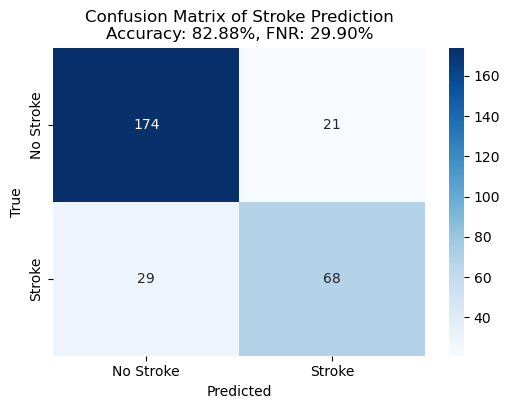

In [1092]:
conf_mat(y_test, y_test_predicted_nn_smote_under)

In [1093]:
scores = cross_val_score(nn_model_smote_under, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1094]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.81839671 0.73679342 0.88113857 0.87248462 0.81764154 0.91544156
 0.88416149]
Mean accuracy: 0.8465797016335469


In [1095]:
report_rf = classification_report(y_pred=y_test_predicted_nn_smote_under,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87       195
         1.0       0.76      0.70      0.73        97

    accuracy                           0.83       292
   macro avg       0.81      0.80      0.80       292
weighted avg       0.83      0.83      0.83       292



#### Decision Tree Classifier

In [1096]:
dt_model_smote_un = DecisionTreeClassifier(**decision_tree_params)

In [1097]:
dt_model_smote_un.fit(X=X_train,y=y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [1098]:
y_test_predicted_dt_smote_und = dt_model_smote_un.predict(X_test)

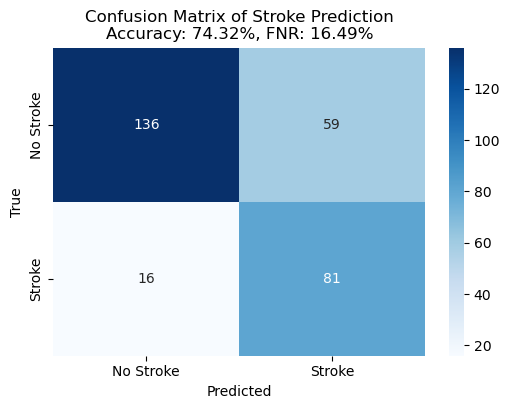

In [1099]:
conf_mat(y_test,y_test_predicted_dt_smote_und)

In [1100]:
scores = cross_val_score(dt_model_smote_un, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1101]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.75955807 0.7200925  0.83088312 0.77994995 0.79856115 0.84240434
 0.77256729]
Mean accuracy: 0.7862880591711192


In [1102]:
report_rf = classification_report(y_pred=y_test_predicted_dt_smote_und,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78       195
         1.0       0.58      0.84      0.68        97

    accuracy                           0.74       292
   macro avg       0.74      0.77      0.73       292
weighted avg       0.79      0.74      0.75       292



#### Random Forest Classifier

In [1103]:
rf_model_smote_und = RandomForestClassifier(**random_forest_params)

In [1104]:
rf_model_smote_und.fit(X=X_train,y=y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [1105]:
y_test_predicted_rf_smote_un = rf_model_smote_und.predict(X_test)

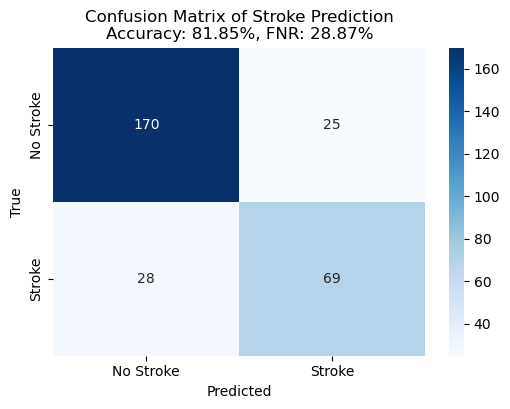

In [1106]:
conf_mat(y_test,y_test_predicted_rf_smote_un)

In [1107]:
scores = cross_val_score(rf_model_smote_und, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1108]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.85775951 0.82929085 0.9106454  0.88979251 0.8687311  0.91262642
 0.92153209]
Mean accuracy: 0.8843396977183116


In [1109]:
report_rf = classification_report(y_pred=y_test_predicted_rf_smote_un,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       195
         1.0       0.73      0.71      0.72        97

    accuracy                           0.82       292
   macro avg       0.80      0.79      0.79       292
weighted avg       0.82      0.82      0.82       292



### Undersample - SMOTE

### Feature Importance

In [1110]:
X = df_scaled_selection.drop(columns=['stroke'])
y = df_scaled_selection['stroke']

In [1111]:
k = 7

In [1112]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

In [1113]:
X

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
1665  0.438477           0.0            0.0           1.0           0.185763   
610   0.682617           0.0            0.0           1.0           0.798449   
3800  0.340820           0.0            0.0           1.0           0.066384   
4297  0.169922           0.0            0.0           0.0           0.167113   
1231  0.035645           0.0            0.0           0.0           0.144308   
...        ...           ...            ...           ...                ...   
5341  0.815461           0.0            0.0           1.0           0.269355   
5342  0.893446           1.0            1.0           1.0           0.656399   
5343  0.691541           0.0            0.0           1.0           0.515249   
5344  0.606786           0.0            0.0           1.0           0.069987   
5345  0.698223           0.0            0.0           1.0           0.653811   

           bmi  Private  never smoked  
1665  0.169530      1.0           1.0  
610   0.215349      1.0           0.0  
3800  0.162658      1.0           1.0  
4297  0.160367      1.0           1.0  
1231  0.143184      0.0           0.0  
...        ...      ...           ...  
5341  0.154895      0.0           0.0  
5342  0.245062      1.0           0.0  
5343  0.212555      0.0           0.0  
5344  0.213984      1.0           1.0  
5345  0.352299      0.0           0.0  

[1458 rows x 8 columns]

In [1114]:
y_df = pd.DataFrame(y, columns=['stroke'])

In [1115]:
df_combined_under_selection = pd.concat([X, y_df], axis=1)

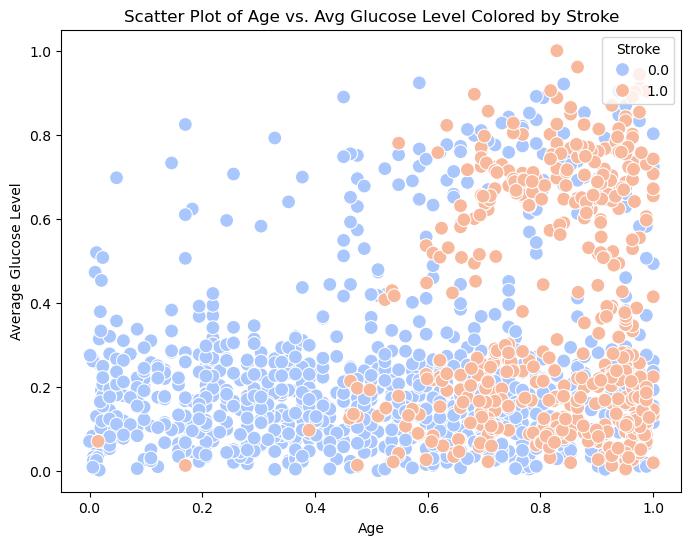

In [1116]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_combined_under_selection, x='age', y='avg_glucose_level', hue='stroke', palette='coolwarm', s=100)
plt.title('Scatter Plot of Age vs. Avg Glucose Level Colored by Stroke')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.legend(title='Stroke', loc='upper right')
plt.show()

In [1117]:
df_combined_under_selection

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
1665  0.438477           0.0            0.0           1.0           0.185763   
610   0.682617           0.0            0.0           1.0           0.798449   
3800  0.340820           0.0            0.0           1.0           0.066384   
4297  0.169922           0.0            0.0           0.0           0.167113   
1231  0.035645           0.0            0.0           0.0           0.144308   
...        ...           ...            ...           ...                ...   
5341  0.815461           0.0            0.0           1.0           0.269355   
5342  0.893446           1.0            1.0           1.0           0.656399   
5343  0.691541           0.0            0.0           1.0           0.515249   
5344  0.606786           0.0            0.0           1.0           0.069987   
5345  0.698223           0.0            0.0           1.0           0.653811   

           bmi  Private  never smoked  stroke  
1665  0.169530      1.0           1.0     0.0  
610   0.215349      1.0           0.0     0.0  
3800  0.162658      1.0           1.0     0.0  
4297  0.160367      1.0           1.0     0.0  
1231  0.143184      0.0           0.0     0.0  
...        ...      ...           ...     ...  
5341  0.154895      0.0           0.0     1.0  
5342  0.245062      1.0           0.0     1.0  
5343  0.212555      0.0           0.0     1.0  
5344  0.213984      1.0           1.0     1.0  
5345  0.352299      0.0           0.0     1.0  

[1458 rows x 9 columns]

In [1118]:
binary_columns = [
    'hypertension',
    'heart_disease', 
    'ever_married',
    'Private',
    'never smoked'
]
for col in binary_columns:
    df_combined_under_selection[col] = (df_combined_under_selection[col] >= 0.5).astype(int)

In [1119]:
df_combined_under_selection

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
1665  0.438477             0              0             1           0.185763   
610   0.682617             0              0             1           0.798449   
3800  0.340820             0              0             1           0.066384   
4297  0.169922             0              0             0           0.167113   
1231  0.035645             0              0             0           0.144308   
...        ...           ...            ...           ...                ...   
5341  0.815461             0              0             1           0.269355   
5342  0.893446             1              1             1           0.656399   
5343  0.691541             0              0             1           0.515249   
5344  0.606786             0              0             1           0.069987   
5345  0.698223             0              0             1           0.653811   

           bmi  Private  never smoked  stroke  
1665  0.169530        1             1     0.0  
610   0.215349        1             0     0.0  
3800  0.162658        1             1     0.0  
4297  0.160367        1             1     0.0  
1231  0.143184        0             0     0.0  
...        ...      ...           ...     ...  
5341  0.154895        0             0     1.0  
5342  0.245062        1             0     1.0  
5343  0.212555        0             0     1.0  
5344  0.213984        1             1     1.0  
5345  0.352299        0             0     1.0  

[1458 rows x 9 columns]

In [1120]:
df_combined_under_selection.nunique()

age                   325
hypertension            2
heart_disease           2
ever_married            2
avg_glucose_level    1375
bmi                   590
Private                 2
never smoked            2
stroke                  2
dtype: int64

In [1121]:
X = df_combined_under_selection.drop(columns=['stroke'])
y = df_combined_under_selection['stroke']

In [1122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression Classifier

In [1123]:
lr_model_smote_und = LogisticRegression(random_state=42,max_iter=1000)

In [1124]:
lr_model_smote_und.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [1125]:
y_test_predicted_smote_under_lr = lr_model_smote_und.predict(X_test)

In [1126]:
(y_test_predicted_smote_under_lr == y_test).sum()/len(y_test)

0.7568493150684932

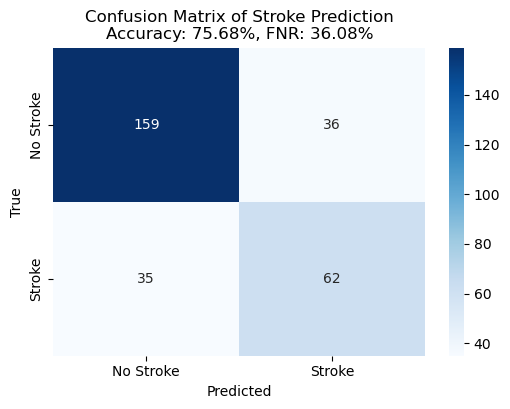

In [1127]:
conf_mat(y_test,y_test_predicted_smote_under_lr)

In [1128]:
scores = cross_val_score(lr_model_smote_und, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1129]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.84881809 0.81778006 0.84141383 0.85913878 0.83390679 0.81680742
 0.86811594]
Mean accuracy: 0.8408544149596029


In [1130]:
report_rf = classification_report(y_pred=y_test_predicted_smote_under_lr,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       195
         1.0       0.63      0.64      0.64        97

    accuracy                           0.76       292
   macro avg       0.73      0.73      0.73       292
weighted avg       0.76      0.76      0.76       292



#### Multi-layer Perceptron Classifier

In [1131]:
nn_model_smote_under = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [1132]:
nn_model_smote_under.fit(X=X_train,y=y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [1133]:
y_test_predicted_nn_smote_under = nn_model_smote_under.predict(X_test)

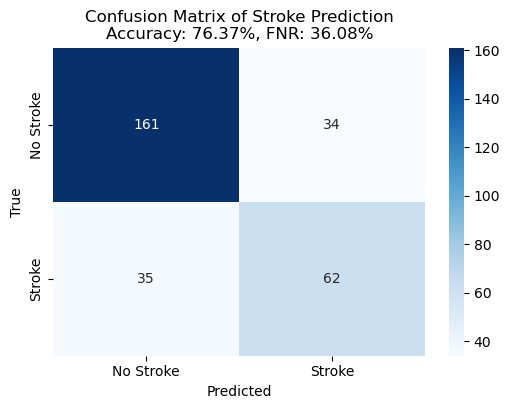

In [1134]:
conf_mat(y_test,y_test_predicted_nn_smote_under)

In [1135]:
scores = cross_val_score(nn_model_smote_under, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1136]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.83823227 0.7979445  0.84568867 0.86476905 0.8531957  0.84193515
 0.88623188]
Mean accuracy: 0.8468567470779366


In [1137]:
report_rf = classification_report(y_pred=y_test_predicted_nn_smote_under,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       195
         1.0       0.65      0.64      0.64        97

    accuracy                           0.76       292
   macro avg       0.73      0.73      0.73       292
weighted avg       0.76      0.76      0.76       292



#### Decision Tree Classifier

In [1138]:
dt_model_smote_un = DecisionTreeClassifier(**decision_tree_params)

In [1139]:
dt_model_smote_un.fit(X=X_train,y=y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [1140]:
y_test_predicted_dt_smote_und = dt_model_smote_un.predict(X_test)

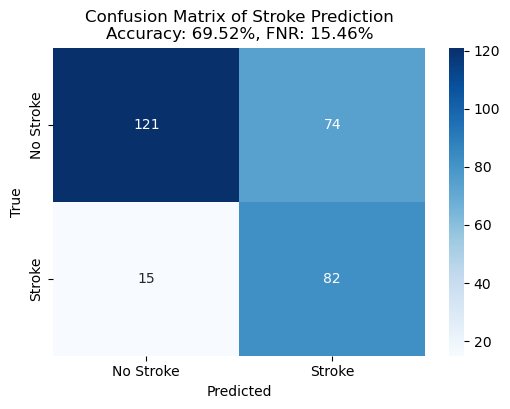

In [1141]:
conf_mat(y_test,y_test_predicted_dt_smote_und)

In [1142]:
scores = cross_val_score(dt_model_smote_un, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1143]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.73437821 0.72733813 0.7837556  0.78730059 0.77296424 0.75482223
 0.80828157]
Mean accuracy: 0.7669772256728778


In [1144]:
report_rf = classification_report(y_pred=y_test_predicted_dt_smote_und,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.89      0.62      0.73       195
         1.0       0.53      0.85      0.65        97

    accuracy                           0.70       292
   macro avg       0.71      0.73      0.69       292
weighted avg       0.77      0.70      0.70       292



#### Random Forest Classifier

In [1145]:
rf_model_smote_und = RandomForestClassifier(**random_forest_params)

In [1146]:
rf_model_smote_und.fit(X=X_train,y=y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=500)

In [1147]:
y_test_predicted_rf_smote_un = rf_model_smote_und.predict(X_test)

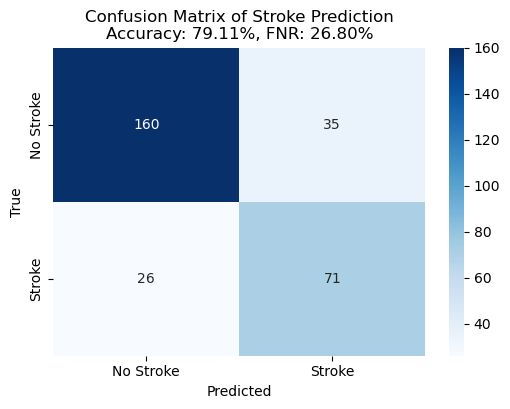

In [1148]:
conf_mat(y_test, y_test_predicted_rf_smote_un)

In [1149]:
scores = cross_val_score(rf_model_smote_und, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [1150]:
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.87482014 0.84676259 0.86184965 0.89615264 0.89385883 0.89886352
 0.92008282]
Mean accuracy: 0.8846271696041569


In [1151]:
report_rf = classification_report(y_pred=y_test_predicted_rf_smote_un,y_true=y_test)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       195
         1.0       0.67      0.73      0.70        97

    accuracy                           0.79       292
   macro avg       0.77      0.78      0.77       292
weighted avg       0.80      0.79      0.79       292

